In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
plt = reload(plt)
from scipy import stats

from datetime import date
import datetime as dt

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

fd_seperator = ':'

id_col_names = ['user_id','coupon_id','date_received']
target_col_name = 'label'
id_target_cols = ['user_id','coupon_id','date_received','label']
myeval = 'roc_auc'
cvscore = 0

datapath = 'C:/Users/Stille/Desktop/ML projects/' 
featurepath = 'C:/Users/Stille/Desktop/ML projects/feature/' 
resultpath = 'C:/Users/Stille/Desktop/ML projects/result/'
tmppath = 'C:/Users/Stille/Desktop/ML projects/tmp/'
scorepath = 'C:/Users/Stille/Desktop/ML projects/score/'

%matplotlib inline

# Get the data

In [2]:
off_train = pd.read_csv('ccf_offline_stage1_train.csv',keep_default_na=True)
off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv',keep_default_na=True)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']

off_train[['user_id','merchant_id','coupon_id']] = off_train[['user_id','merchant_id','coupon_id']].astype(str)
off_test[['user_id','merchant_id','coupon_id']] = off_test[['user_id','merchant_id','coupon_id']].astype(str)

# Explore the data

In [3]:
off_train.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
0,1439408,2632,nan,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


In [4]:
off_test.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


In [5]:
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   merchant_id    object 
 2   coupon_id      object 
 3   discount_rate  object 
 4   distance       float64
 5   date_received  float64
 6   date           float64
dtypes: float64(3), object(4)
memory usage: 93.7+ MB


Discount_rate: range in [0,1], 'fixed' means Limited Time Offer;
Distance (only in off_train): 500x, the distance from the nearest shop around the user for locations in which a user is most active. x range in [0,10]; 0 – less than 500 meters; 10 – more than 5 kilometres.

In [6]:
off_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113640 entries, 0 to 113639
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        113640 non-null  object 
 1   merchant_id    113640 non-null  object 
 2   coupon_id      113640 non-null  object 
 3   discount_rate  113640 non-null  object 
 4   distance       101576 non-null  float64
 5   date_received  113640 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ MB


In [7]:
off_train.describe()

,distance,date_received,date
count,1.648881e+06,1.053282e+06,7.769840e+05
mean,2.361636e+00,2.016032e+07,2.016040e+07
std,3.483974e+00,1.771416e+02,1.621500e+02
min,0.000000e+00,2.016010e+07,2.016010e+07
25%,0.000000e+00,2.016013e+07,2.016031e+07
50%,0.000000e+00,2.016032e+07,2.016042e+07
75%,3.000000e+00,2.016051e+07,2.016052e+07
max,1.000000e+01,2.016062e+07,2.016063e+07


In [8]:
off_test.describe()

,distance,date_received
count,101576.000000,1.136400e+05
mean,2.328040,2.016072e+07
std,3.260755,9.019508e+00
min,0.000000,2.016070e+07
25%,0.000000,2.016071e+07
50%,1.000000,2.016072e+07
75%,3.000000,2.016072e+07
max,10.000000,2.016073e+07


In [9]:
off_train.isnull().sum()

user_id               0
merchant_id           0
coupon_id             0
discount_rate    701602
distance         106003
date_received    701602
date             977900
dtype: int64

In [10]:
off_test.isnull().sum()

user_id              0
merchant_id          0
coupon_id            0
discount_rate        0
distance         12064
date_received        0
dtype: int64

In [11]:
# find the range of date of the data
off_train = pd.read_csv('ccf_offline_stage1_train.csv',keep_default_na=False)
off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv',keep_default_na=False)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']

off_train[['user_id','merchant_id','coupon_id']] = off_train[['user_id','merchant_id','coupon_id']].astype(str)
off_test[['user_id','merchant_id','coupon_id']] = off_test[['user_id','merchant_id','coupon_id']].astype(str)

In [12]:
print('offline train date_received')
print(off_train[off_train['date_received']!='null']['date_received'].min())
print(off_train[off_train['date_received']!='null']['date_received'].max())

print('test date_received')
print(off_test['date_received'].min())
print(off_test['date_received'].max())

offline train date_received
20160101
20160615
test date_received
20160701
20160731


In [13]:
print('offline train date')
print(off_train[off_train['date']!='null']['date'].min())
print(off_train[off_train['date']!='null']['date'].max())

offline train date
20160101
20160630


In [14]:
off_train['discount_rate'].value_counts()

null       701602
30:5       270712
100:10     182554
200:20     111046
20:5        91013
20:1        51705
50:5        47379
100:30      38196
200:30      29327
300:30      28979
50:10       28452
10:5        25925
0.95        20568
10:1        17842
30:1        17654
150:20      17437
100:20      14297
30:10       12692
50:20        8203
0.9          8085
200:50       5585
150:10       5325
100:5        5053
0.8          3441
50:1         3354
5:1          2526
100:50       1774
150:30        654
0.85          649
200:10        575
100:1         537
20:10         514
150:50        306
300:50        206
0.5           186
0.75          121
0.2           110
0.6            58
200:5          57
300:20         56
0.7            54
30:20          24
300:10         23
200:100        12
50:30           9
150:5           7
Name: discount_rate, dtype: int64

In [15]:
off_test['discount_rate'].value_counts()

30:5       59318
20:1       11273
50:10       7476
20:5        7026
200:20      5496
30:1        4016
10:1        3758
100:10      3706
50:5        2693
100:20      2327
0.95         991
0.9          827
0.8          735
150:5        495
100:5        467
30:10        407
10:5         346
50:1         339
200:30       258
150:20       248
100:30       229
150:30       181
5:1          171
300:30       136
200:50       124
20:10        114
100:50        97
50:20         97
150:50        92
150:10        61
30:20         32
200:10        26
300:50        19
200:5         18
100:1         14
0.5           10
300:20        10
200:100        3
0.6            1
500:30         1
0.7            1
0.85           1
Name: discount_rate, dtype: int64

In [16]:
off_train['distance'].value_counts()

0       826070
1       227221
10      206484
2       118413
null    106003
3        76598
4        55085
5        41452
6        32483
7        25681
8        21436
9        17958
Name: distance, dtype: int64

In [17]:
off_test['distance'].value_counts()

0       43867
1       18474
null    12064
10      10353
2        9523
3        5934
4        4006
5        2977
6        2179
7        1685
8        1359
9        1219
Name: distance, dtype: int64

In [18]:
# Convert/build basic features

def get_discount_rate(s):
    s = str(s)
    if s == 'null':
        return -1
    s = s.split(fd_seperator)
    if len(s) == 1:
        return float(s[0])
    else:
        return round((1.0-float(s[1]) / float(s[0])), 3)

# # if full-reduction promotion
def get_if_fd(s):
    s = str(s)
    s = s.split(fd_seperator)
    if len(s) == 1:
        return 0
    else:
        return 1
        
def get_full_value(s):
    s = str(s)
    s = s.split(fd_seperator)
    if len(s) == 1:
        return np.nan
    else:
        return int(s[0])
          
def get_reduction_value(s):
    s = str(s)
    s = s.split(fd_seperator)
    if len(s) == 1:
        return np.nan
    else:
        return int(s[1])

# days took for customers redeeming the coupon
def get_day_gap(s):
    s = s.split(fd_seperator)
    if s[0] == 'null':
        return -1
    if s[1] == 'null':
        return -1
    else:    
        return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days


# customers redeeming a coupon within 15 days of receiving it
def get_label(s):
    s = s.split(fd_seperator)
    if s[0] == 'null':
        return 0
    if s[1] == 'null':
        return -1
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return 0

In [19]:
def add_feature(df):
    df['if_fd'] = df['discount_rate'].apply(get_if_fd)
    df['full_value'] = df['discount_rate'].apply(get_full_value)
    df['reduction_value'] = df['discount_rate'].apply(get_reduction_value)
    df['discount_rate'] = df['discount_rate'].apply(get_discount_rate)
    df['distance'] = df['distance'].replace('null', -1).astype(int)

    return df
    
def add_label(df):
    df['day_gap'] = df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['label'] = df['day_gap'].apply(get_label)
    df['day_gap'] = df['day_gap'].apply(get_day_gap)
    return df

In [20]:
# make copies of data
dftrain = off_train.copy()
dftest = off_test.copy()

In [21]:
dftrain = add_feature(dftrain)
dftrain = add_label(dftrain)
dftest = add_feature(dftest)

In [22]:
dftrain.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date,if_fd,full_value,reduction_value,day_gap,label
0,1439408,2632,null,-1.000,0,null,20160217,0,NaN,NaN,-1,-1
1,1439408,4663,11002,0.867,1,20160528,null,1,150.0,20.0,-1,0
2,1439408,2632,8591,0.950,0,20160217,null,1,20.0,1.0,-1,0
3,1439408,2632,1078,0.950,0,20160319,null,1,20.0,1.0,-1,0
4,1439408,2632,8591,0.950,0,20160613,null,1,20.0,1.0,-1,0


In [23]:
dftrain.describe()

,discount_rate,distance,if_fd,full_value,reduction_value,day_gap,label
count,1.754884e+06,1.754884e+06,1.754884e+06,1.020010e+06,1.020010e+06,1.754884e+06,1.754884e+06
mean,1.069263e-01,2.158577e+00,5.812407e-01,8.099656e+01,1.071230e+01,-6.212582e-01,-3.631049e-01
std,9.061336e-01,3.470772e+00,4.933559e-01,7.218772e+01,9.114281e+00,2.414021e+00,5.519505e-01
min,-1.000000e+00,-1.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,5.000000e+00,-1.000000e+00,-1.000000e+00
50%,7.500000e-01,0.000000e+00,1.000000e+00,5.000000e+01,5.000000e+00,-1.000000e+00,0.000000e+00
75%,9.000000e-01,3.000000e+00,1.000000e+00,1.000000e+02,2.000000e+01,-1.000000e+00,0.000000e+00
max,9.900000e-01,1.000000e+01,1.000000e+00,3.000000e+02,1.000000e+02,9.600000e+01,1.000000e+00


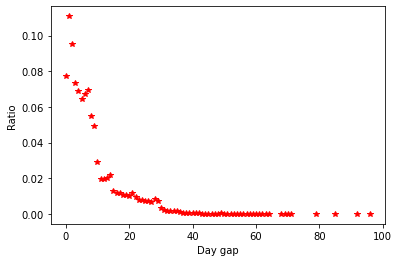

In [24]:
serie_dayGap = dftrain[dftrain.day_gap >= 0]["day_gap"].value_counts()/dftrain[dftrain.day_gap >= 0]["day_gap"].count()

plt.plot(serie_dayGap.index, serie_dayGap.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Day gap")
plt.ylabel("Ratio")
plt.show()

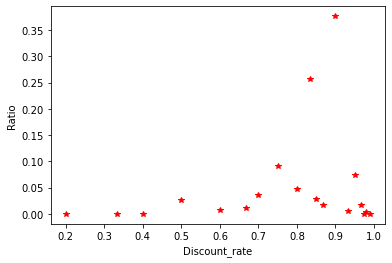

In [25]:
serie_discount = dftrain[dftrain.discount_rate >= 0]['discount_rate'].value_counts()/dftrain[dftrain.discount_rate >= 0]['discount_rate'].count()

plt.plot(serie_discount.index, serie_discount.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Discount_rate")
plt.ylabel("Ratio")
plt.show()

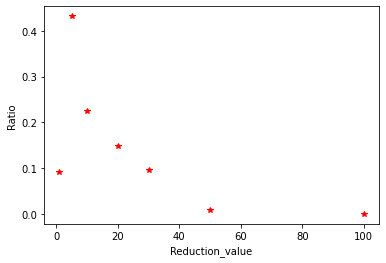

In [26]:
serie_reduction = dftrain[dftrain.reduction_value>0]['reduction_value'].value_counts()/dftrain[dftrain.reduction_value>0]['reduction_value'].count()

plt.plot(serie_reduction.index, serie_reduction.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Reduction_value")
plt.ylabel("Ratio")
plt.show()

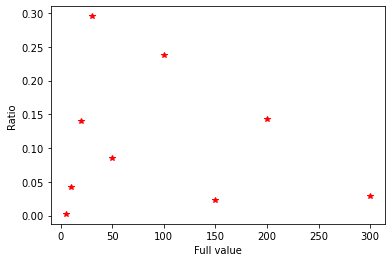

In [27]:
serie_full = dftrain[dftrain.full_value>0]['full_value'].value_counts()/dftrain[dftrain.full_value>0]['full_value'].count()

plt.plot(serie_full.index, serie_full.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Full value")
plt.ylabel("Ratio")
plt.show()

In [28]:
dftrain['if_fd'].value_counts()

1    1020010
0     734874
Name: if_fd, dtype: int64

In [29]:
dftrain['label'].value_counts()/dftrain['label'].count()

 0    0.563506
-1    0.399800
 1    0.036695
Name: label, dtype: float64

In [30]:
dftest.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,if_fd,full_value,reduction_value
0,4129537,450,9983,0.833,1,20160712,1,30.0,5.0
1,6949378,1300,3429,0.833,-1,20160706,1,30.0,5.0
2,2166529,7113,6928,0.900,5,20160727,1,200.0,20.0
3,2166529,7113,1808,0.900,5,20160727,1,100.0,10.0
4,6172162,7605,6500,0.967,2,20160708,1,30.0,1.0


In [31]:
dftest.describe()

,discount_rate,distance,date_received,if_fd,full_value,reduction_value
count,113640.000000,113640.000000,1.136400e+05,113640.000000,111074.000000,111074.000000
mean,0.850512,1.974736,2.016072e+07,0.977420,44.422142,6.252912
std,0.063620,3.248809,9.019508e+00,0.148561,44.224297,5.600019
min,0.333000,-1.000000,2.016070e+07,0.000000,5.000000,1.000000
25%,0.833000,0.000000,2.016071e+07,1.000000,30.000000,5.000000
50%,0.833000,1.000000,2.016072e+07,1.000000,30.000000,5.000000
75%,0.900000,3.000000,2.016072e+07,1.000000,30.000000,5.000000
max,0.990000,10.000000,2.016073e+07,1.000000,500.000000,100.000000


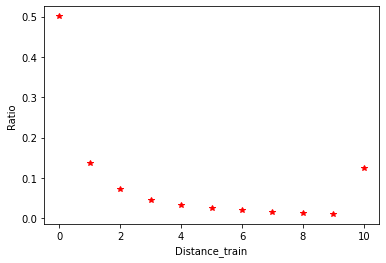

In [32]:
serie_train = dftrain[dftrain.distance >= 0]['distance'].value_counts()/dftrain[dftrain.distance >= 0]['distance'].count()

plt.plot(serie_train.index, serie_train.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Distance_train")
plt.ylabel("Ratio")
plt.show()

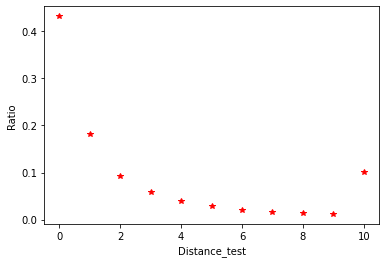

In [33]:
serie_test = dftest[dftest.distance >= 0]['distance'].value_counts()/dftest[dftest.distance >= 0]['distance'].count()

plt.plot(serie_test.index, serie_test.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Distance_test")
plt.ylabel("Ratio")
plt.show()

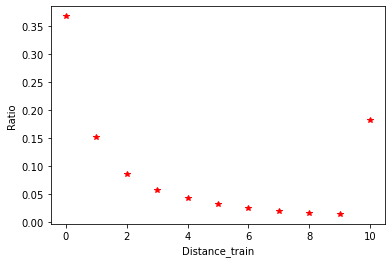

In [34]:
# positive labels
serie_train_label = dftrain[(dftrain.label >= 0)&(dftrain.distance >= 0)]['distance'].value_counts()/dftrain[(dftrain.label >= 0)&(dftrain.distance >= 0)]['distance'].count()

plt.plot(serie_train_label.index, serie_train_label.values, linestyle="None", marker = "*", color = "r")
plt.xlabel("Distance_train")
plt.ylabel("Ratio")
plt.show()

In [35]:
print ('Offline training set, ratio of full reduction promotion')
dftrain.if_fd.value_counts() / dftrain.if_fd.count()

Offline training set, ratio of full reduction promotion


1    0.581241
0    0.418759
Name: if_fd, dtype: float64

In [36]:
print ('Testing set, ratio of full reduction promotion')
dftest.if_fd.value_counts() / dftest.if_fd.count()

Testing set, ratio of full reduction promotion


1    0.97742
0    0.02258
Name: if_fd, dtype: float64

# Feature engineering

In [37]:
# add discount related features
def add_discount(df):
    df['if_fd'] = df['discount_rate'].apply(get_if_fd)
    df['full_value'] = df['discount_rate'].apply(get_full_value)
    df['reduction_value'] = df['discount_rate'].apply(get_reduction_value)
    df['discount_rate'] = df['discount_rate'].apply(get_discount_rate)
    df.distance = df.distance.replace('null',np.nan)
    return df

# add day-gap features
def add_day_gap(df):
    df['day_gap'] = df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['day_gap'] = df['day_gap'].apply(get_day_gap)
    return df

# add label
def add_label(df):
    df['label'] = df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['label'] = df['label'].apply(get_label)
    return df

def is_firstlastone(x):
    if x == 0:
        return 1
    elif x > 0:
        return 0
    else:
        return np.nan

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        # convert time difference
        this_gap = (dt.date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-dt.date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap > 0:
            gaps.append(this_gap)
    if len(gaps) == 0:
        return np.nan
    else:
        return min(gaps)
    
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (dt.datetime(int(d[0:4]),int(d[4:6]),int(d[6:8]))-dt.datetime(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap > 0:
            gaps.append(this_gap)
    if len(gaps) == 0:
        return np.nan
    else:
        return min(gaps)
    
    
# add aggregation features
def add_agg_feature_names(df, df_group, group_cols, value_col, agg_ops, col_names):
    df_group[value_col] = df_group[value_col].astype('float')
    df_agg = pd.DataFrame(df_group.groupby(group_cols)[value_col].agg(agg_ops)).reset_index()
    df_agg.columns = group_cols + col_names
    df = df.merge(df_agg, on = group_cols, how = "left")
    return df    

def add_agg_feature(df, df_group, group_cols, value_col, agg_ops, keyword):
    col_names = []
    for op in agg_ops:
        col_names.append(keyword + '_' + value_col + '_' + op)
    df = add_agg_feature_names(df, df_group, group_cols, value_col, agg_ops, col_names)
    return df

def add_count_new_feature(df, df_group, group_cols, new_feature_name):
    df_group[new_feature_name] = 1
    df_group = df_group.groupby(group_cols).agg('sum').reset_index()
    df = df.merge(df_group, on = group_cols, how = "left")
    return df

In [38]:
# Get merchant related features
def get_merchant_feature(feature):
    merchant = feature[['merchant_id','coupon_id','distance','date_received','date']].copy()
    t = merchant[['merchant_id']].copy()
    t.drop_duplicates(inplace = True)

    # sold out items
    t1 = merchant[merchant.date!='null'][['merchant_id']].copy()
    merchant_feature = add_count_new_feature(t, t1, 'merchant_id', 'total_sales')

    # sold out items with coupons
    t2 = merchant[(merchant.date!='null')&(merchant.coupon_id!='null')][['merchant_id']].copy()
    merchant_feature=add_count_new_feature(merchant_feature, t2, 'merchant_id', 'sales_use_coupon')

    # total number of coupons
    t3 = merchant[merchant.coupon_id != 'null'][['merchant_id']].copy()
    merchant_feature=add_count_new_feature(merchant_feature, t3, 'merchant_id', 'total_coupon')
    
    # relation between sales and distance
    t4 = merchant[(merchant.date != 'null')&(merchant.coupon_id != 'null')&(merchant.distance != 'null')][['merchant_id','distance']].copy()
    t4.distance = t4.distance.astype('int')
    merchant_feature = add_agg_feature(merchant_feature, t4, ['merchant_id'], 'distance', ['min','max','mean','median'], 'merchant')

    # replace nan with 0
    merchant_feature.sales_use_coupon = merchant_feature.sales_use_coupon.replace(np.nan, 0)
    # usage ratio of coupons
    merchant_feature['merchant_coupon_transfer_rate'] = merchant_feature.sales_use_coupon.astype('float')/merchant_feature.total_coupon
    # coupon-using rate of sold out items
    merchant_feature['coupon_rate'] = merchant_feature.sales_use_coupon.astype('float') / merchant_feature.total_sales
    # replace nan with 0
    merchant_feature.total_coupon = merchant_feature.total_coupon.replace(np.nan, 0)

    return merchant_feature



In [39]:
# obtain user related features
def get_user_feature(feature):
    user = feature[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']].copy()

    t = user[['user_id']].copy()
    t.drop_duplicates(inplace = True)
     
    # total items that user purchased
    t1 = user[user.date!='null'][['user_id','merchant_id']].copy()
    t1.drop_duplicates(inplace=True)
    t1 = t1[['user_id']]
    user_feature = add_count_new_feature(t, t1, 'user_id', 'count_merchant')

    # distance statistics
    t2 = user[(user.date!='null')&(user.coupon_id!='null')&(user.distance != 'null')][['user_id','distance']]
    t2.distance = t2.distance.astype('int')
    user_feature = add_agg_feature(user_feature, t2, ['user_id'], 'distance', ['min','max','mean','median'], 'user')

    # counting times that user used coupon to buy items
    t7 = user[(user.date!='null')&(user.coupon_id!='null')][['user_id']]
    user_feature = add_count_new_feature(user_feature, t7, 'user_id', 'buy_use_coupon')
    
    # total number of buying items
    t8 = user[user.date!='null'][['user_id']]
    user_feature = add_count_new_feature(user_feature, t8, 'user_id', 'buy_total')
    
    # coupon received times
    t9 = user[user.coupon_id!='null'][['user_id']]
    user_feature = add_count_new_feature(user_feature, t9, 'user_id', 'coupon_received')
    
    # day gap statistics
    t10 = user[(user.date_received!='null')&(user.date!='null')][['user_id','date_received','date']]
    t10 = add_day_gap(t10)
    t10 = t10[['user_id','day_gap']]
    user_feature = add_agg_feature(user_feature, t10, ['user_id'], 'day_gap', ['min','max','mean','median'], 'user')

    user_feature.count_merchant = user_feature.count_merchant.replace(np.nan,0)
    user_feature.buy_use_coupon = user_feature.buy_use_coupon.replace(np.nan,0)
    # usage ratio of coupons for users
    user_feature['buy_use_coupon_rate'] = user_feature.buy_use_coupon.astype('float') / user_feature.buy_total.astype('float')
    # coupon transfer rate for users
    user_feature['user_coupon_transfer_rate'] = user_feature.buy_use_coupon.astype('float') / user_feature.coupon_received.astype('float')
    user_feature.buy_total = user_feature.buy_total.replace(np.nan,0)
    user_feature.coupon_received = user_feature.coupon_received.replace(np.nan,0)
    return user_feature

In [40]:
# features related both users and merchants
def get_user_merchant_feature(feature):
    t = feature[['user_id','merchant_id']].copy()
    t.drop_duplicates(inplace=True)

    # purchasing times of one user at one merchant
    t0 = feature[['user_id','merchant_id','date']].copy()
    t0 = t0[t0.date!='null'][['user_id','merchant_id']]    
    user_merchant = add_count_new_feature(t, t0, ['user_id','merchant_id'], 'user_merchant_buy_total')
    
    # number of coupons received of one user at one merchant
    t1 = feature[['user_id','merchant_id','coupon_id']]
    t1 = t1[t1.coupon_id!='null'][['user_id','merchant_id']]
    user_merchant = add_count_new_feature(user_merchant, t1, ['user_id','merchant_id'], 'user_merchant_received')
    
    # using times of coupons of one user at one merchant
    t2 = feature[['user_id','merchant_id','date','date_received']]
    t2 = t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
    user_merchant = add_count_new_feature(user_merchant, t2, ['user_id','merchant_id'], 'user_merchant_buy_use_coupon')
    
    # search times of one user at one merchant
    t3 = feature[['user_id','merchant_id']]
    user_merchant = add_count_new_feature(user_merchant, t3, ['user_id','merchant_id'], 'user_merchant_any')
    
    # buying times of one user at one merchant without using coupons
    t4 = feature[['user_id','merchant_id','date','coupon_id']]
    t4 = t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
    user_merchant = add_count_new_feature(user_merchant, t4, ['user_id','merchant_id'], 'user_merchant_buy_common')
    
    user_merchant.user_merchant_buy_use_coupon = user_merchant.user_merchant_buy_use_coupon.replace(np.nan,0)
    user_merchant.user_merchant_buy_common = user_merchant.user_merchant_buy_common.replace(np.nan,0)
    user_merchant['user_merchant_coupon_transfer_rate'] = user_merchant.user_merchant_buy_use_coupon.astype('float') / user_merchant.user_merchant_received.astype('float')
    user_merchant['user_merchant_coupon_buy_rate'] = user_merchant.user_merchant_buy_use_coupon.astype('float') / user_merchant.user_merchant_buy_total.astype('float')
    user_merchant['user_merchant_rate'] = user_merchant.user_merchant_buy_total.astype('float') / user_merchant.user_merchant_any.astype('float')
    user_merchant['user_merchant_common_buy_rate'] = user_merchant.user_merchant_buy_common.astype('float') / user_merchant.user_merchant_buy_total.astype('float')
    return user_merchant

In [41]:
# get leakage features
def get_leakage_feature(dataset):
    t = dataset[['user_id']].copy()
    t['this_month_user_receive_all_coupon_count'] = 1
    t = t.groupby('user_id').agg('sum').reset_index()
    
    t1 = dataset[['user_id','coupon_id']].copy()
    t1['this_month_user_receive_same_coupn_count'] = 1
    t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()
        
    t2 = dataset[['user_id','coupon_id','date_received']].copy()
    t2.date_received = t2.date_received.astype('str')
    t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
    t2 = t2[t2.receive_number > 1]
    # max received date
    t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
    # min received date
    t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
    t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

    t3 = dataset[['user_id','coupon_id','date_received']]
    t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
    t3['this_month_user_receive_same_coupon_lastone']= t3.max_date_received-t3.date_received.astype(int)
    t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype(int)-t3.min_date_received
    
    t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]
       
    # total number of coupons that one user received on one date
    t4 = dataset[['user_id','date_received']].copy()
    t4['this_day_receive_all_coupon_count'] = 1
    t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

    # different number of coupons user received at different time
    t5 = dataset[['user_id','coupon_id','date_received']].copy()
    t5['this_day_user_receive_same_coupon_count'] = 1
    t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()
    
    # different receiving time of coupons for one user
    t6 = dataset[['user_id','coupon_id','date_received']].copy()
    t6.date_received = t6.date_received.astype('str')
    t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    t6.rename(columns={'date_received':'dates'},inplace = True)
    
    t7 = dataset[['user_id','coupon_id','date_received']]
    t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
    t7['date_received_date'] = t7.date_received.astype('str')+'-'+t7.dates
    t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
    t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
    t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]
    
    other_feature = pd.merge(t1,t,on='user_id')
    other_feature = pd.merge(other_feature,t3,on=['user_id','coupon_id'])
    other_feature = pd.merge(other_feature,t4,on=['user_id','date_received'])
    other_feature = pd.merge(other_feature,t5,on=['user_id','coupon_id','date_received'])
    other_feature = pd.merge(other_feature,t7,on=['user_id','coupon_id','date_received'])
    return other_feature

In [42]:
# f1, basic features
def f1(dataset, if_train):
    result = add_discount(dataset) 
    result.drop_duplicates(inplace = True)
    if if_train:
        result = add_label(result)
    return result

# f2, add Merchant, user features
def f2(dataset, feature, if_train):
       
    result = add_discount(dataset)
    
    merchant_feature = get_merchant_feature(feature)
    result = result.merge(merchant_feature, on = 'merchant_id', how = "left")
    
    user_feature = get_user_feature(feature)
    result = result.merge(user_feature, on = 'user_id', how = "left")
    
    user_merchant = get_user_merchant_feature(feature)
    result = result.merge(user_merchant, on = ['user_id','merchant_id'], how = "left")
    
    result.drop_duplicates(inplace = True)
    
    if if_train:
        result = add_label(result)
     
    return result

# f3, add leakage features
def f3(dataset,feature,if_train):
       
    result = add_discount(dataset)
    
    merchant_feature = get_merchant_feature(feature)
    result = result.merge(merchant_feature, on = 'merchant_id', how = "left")
    
    user_feature = get_user_feature(feature)
    result = result.merge(user_feature, on = 'user_id', how = "left")
    
    user_merchant = get_user_merchant_feature(feature)
    result = result.merge(user_merchant, on = ['user_id','merchant_id'], how = "left")
    
    leakage_feature = get_leakage_feature(dataset)
    result = result.merge(leakage_feature, on = ['user_id','coupon_id','date_received'], how = 'left')
    
    result.drop_duplicates(inplace = True)
    if if_train:
        result = add_label(result)
     
    return result

In [43]:
# generate normal features
def normal_feature_generate(feature_function):
    off_train = pd.read_csv('ccf_offline_stage1_train.csv',header=0,keep_default_na=False)
    off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']

    off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv',header=0,keep_default_na=False)
    off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
    
    off_train = off_train[(off_train.coupon_id!='null')&(off_train.date_received!='null')&(off_train.date_received>='20160501')]
   
    dftrain = feature_function(off_train,True)
    
    dftest = feature_function(off_test,False)
    
    dftrain.drop(['date'], axis=1, inplace=True)
    dftrain.drop(['merchant_id'], axis=1, inplace=True)
    dftest.drop(['merchant_id'], axis=1, inplace=True)
    
    # generate features
    dftrain.to_csv(featurepath+'train_'+feature_function.__name__+'.csv',index=False,sep=',')
    dftest.to_csv(featurepath+'test_'+feature_function.__name__+'.csv',index=False,sep=',')
    print('features generated')


In [44]:
# generate slide features
def slide_feature_generate(feature_function):
    off_train = pd.read_csv('ccf_offline_stage1_train.csv',header=0,keep_default_na=False)
    off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']

    off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv',header=0,keep_default_na=False)
    off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
    
    # date between 4/14 and 5/14
    dataset1 = off_train[(off_train.date_received>='201604014')&(off_train.date_received<='20160514')]
    # date between 1/1 and 4/13
    feature1 = off_train[(off_train.date>='20160101')&(off_train.date<='20160413')|((off_train.date=='null')&(off_train.date_received>='20160101')&(off_train.date_received<='20160413'))]
    
    # date between 5/15 and 6/15
    dataset2 = off_train[(off_train.date_received>='20160515')&(off_train.date_received<='20160615')]
    # date between 2/1 and 5/14
    feature2 = off_train[(off_train.date>='20160201')&(off_train.date<='20160514')|((off_train.date=='null')&(off_train.date_received>='20160201')&(off_train.date_received<='20160514'))]
    
    # testing set
    dataset3 = off_test
    # testing set feature, date between 3/15 and 6/30
    feature3 = off_train[((off_train.date>='20160315')&(off_train.date<='20160630'))|((off_train.date=='null')&(off_train.date_received>='20160315')&(off_train.date_received<='20160630'))]
    
    dftrain1 = feature_function(dataset1,feature1,True)
    dftrain2 = feature_function(dataset2,feature2,True)
    dftrain = pd.concat([dftrain1,dftrain2],axis=0)
       
    dftest = feature_function(dataset3,feature3,False)
    
    dftrain.drop(['date'], axis=1, inplace=True)
    dftrain.drop(['merchant_id'], axis=1, inplace=True)
    dftest.drop(['merchant_id'], axis=1, inplace=True)
    
    # generate features
    dftrain.to_csv(featurepath+'train_s'+feature_function.__name__+'.csv',index=False,sep=',')
    dftest.to_csv(featurepath+'test_s'+feature_function.__name__+'.csv',index=False,sep=',')
    print('features generated')

In [45]:
# f1
normal_feature_generate(f1)
# sf2
slide_feature_generate(f2)
# sf3
slide_feature_generate(f3)

features generated
features generated
features generated


In [46]:
# return id columns
def get_id_df(df):
    return df[id_col_names]

# return target column
def get_target_df(df):
    return df[target_col_name]

# return predictor columns
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

# read train data based on feature names
def read_featurefile_train(featurename): 
    df = pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    # fill missing values
    df.fillna(0,inplace=True)
    return df

# read test data based on feature names
def read_featurefile_test(featurename): 
    df = pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    # fill missing values
    df.fillna(0,inplace=True)
    return df

# read data based on feature names
def read_data(featurename): 
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf, testdf  

In [47]:
# analysis on sf3
traindf, testdf = read_data('sf3')
train_X = get_predictors_df(traindf)
train_y = get_target_df(traindf)
test_X = get_predictors_df(testdf)

In [48]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438166 entries, 0 to 438165
Data columns (total 49 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   user_id                                       438166 non-null  int64  
 1   coupon_id                                     438166 non-null  int64  
 2   discount_rate                                 438166 non-null  float64
 3   distance                                      438166 non-null  float64
 4   date_received                                 438166 non-null  int64  
 5   if_fd                                         438166 non-null  int64  
 6   full_value                                    438166 non-null  float64
 7   reduction_value                               438166 non-null  float64
 8   total_sales                                   438166 non-null  float64
 9   sales_use_coupon                              43

In [49]:
traindf.describe()

,user_id,coupon_id,discount_rate,distance,date_received,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,...,user_merchant_common_buy_rate,this_month_user_receive_same_coupn_count,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label
count,4.381660e+05,438166.000000,438166.000000,438166.000000,4.381660e+05,438166.000000,438166.000000,438166.000000,438166.000000,438166.000000,...,438166.000000,438166.000000,438166.000000,438166.00000,438166.000000,438166.000000,438166.000000,438166.000000,438166.000000,438166.000000
mean,3.682005e+06,6382.714369,0.841735,2.091803,2.016051e+07,0.975957,65.209761,9.315851,3849.085970,395.584329,...,0.223281,1.313899,2.222995,0.03888,0.062837,1.135716,1.008332,0.330078,0.330388,0.076403
std,2.123942e+06,3801.424670,0.089430,3.239931,6.824082e+01,0.153184,66.481403,9.272592,4556.384419,630.360653,...,0.410554,1.717467,2.734152,0.19331,0.242670,0.480628,0.111041,1.850177,1.850832,0.265641
min,4.000000e+00,1.000000,0.333000,0.000000,2.016040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.838974e+06,2705.000000,0.833000,0.000000,2.016043e+07,1.000000,20.000000,5.000000,171.000000,6.000000,...,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.682408e+06,6036.000000,0.833000,0.000000,2.016052e+07,1.000000,30.000000,5.000000,1649.000000,105.000000,...,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.523967e+06,9487.000000,0.900000,3.000000,2.016053e+07,1.000000,100.000000,20.000000,6307.000000,408.000000,...,0.000000,1.000000,2.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,7.360961e+06,14045.000000,0.990000,10.000000,2.016062e+07,1.000000,300.000000,100.000000,20717.000000,2414.000000,...,1.000000,56.000000,57.000000,1.00000,1.000000,12.000000,8.000000,42.000000,42.000000,1.000000


In [50]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112803 entries, 0 to 112802
Data columns (total 48 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   user_id                                       112803 non-null  int64  
 1   coupon_id                                     112803 non-null  int64  
 2   discount_rate                                 112803 non-null  float64
 3   distance                                      112803 non-null  float64
 4   date_received                                 112803 non-null  int64  
 5   if_fd                                         112803 non-null  int64  
 6   full_value                                    112803 non-null  float64
 7   reduction_value                               112803 non-null  float64
 8   total_sales                                   112803 non-null  float64
 9   sales_use_coupon                              11

In [51]:
testdf.describe()

,user_id,coupon_id,discount_rate,distance,date_received,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,...,user_merchant_rate,user_merchant_common_buy_rate,this_month_user_receive_same_coupn_count,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after
count,1.128030e+05,112803.000000,112803.000000,112803.000000,1.128030e+05,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000,...,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000,112803.000000
mean,3.684618e+06,9064.658006,0.850368,2.083703,2.016072e+07,0.977323,43.462009,6.122249,6115.497841,1026.385788,...,0.166271,0.171676,1.324938,2.398784,0.035407,0.060681,1.159233,1.007420,0.317917,0.317917
std,2.126358e+06,4147.283515,0.063048,3.165163,9.017693e+00,0.148871,44.237398,5.606292,6118.238154,1129.205824,...,0.343672,0.363612,1.627665,4.619822,0.184807,0.238745,0.519234,0.123511,1.752391,1.752391
min,2.090000e+02,3.000000,0.333000,0.000000,2.016070e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.843824e+06,5035.000000,0.833000,0.000000,2.016071e+07,1.000000,30.000000,5.000000,461.000000,55.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,3.683073e+06,9983.000000,0.833000,1.000000,2.016072e+07,1.000000,30.000000,5.000000,4847.000000,525.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,5.525176e+06,13602.000000,0.900000,3.000000,2.016072e+07,1.000000,30.000000,5.000000,15146.000000,2723.000000,...,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,7.361024e+06,14045.000000,0.990000,10.000000,2.016073e+07,1.000000,500.000000,100.000000,16292.000000,3102.000000,...,1.000000,1.000000,37.000000,97.000000,1.000000,1.000000,26.000000,26.000000,30.000000,30.000000


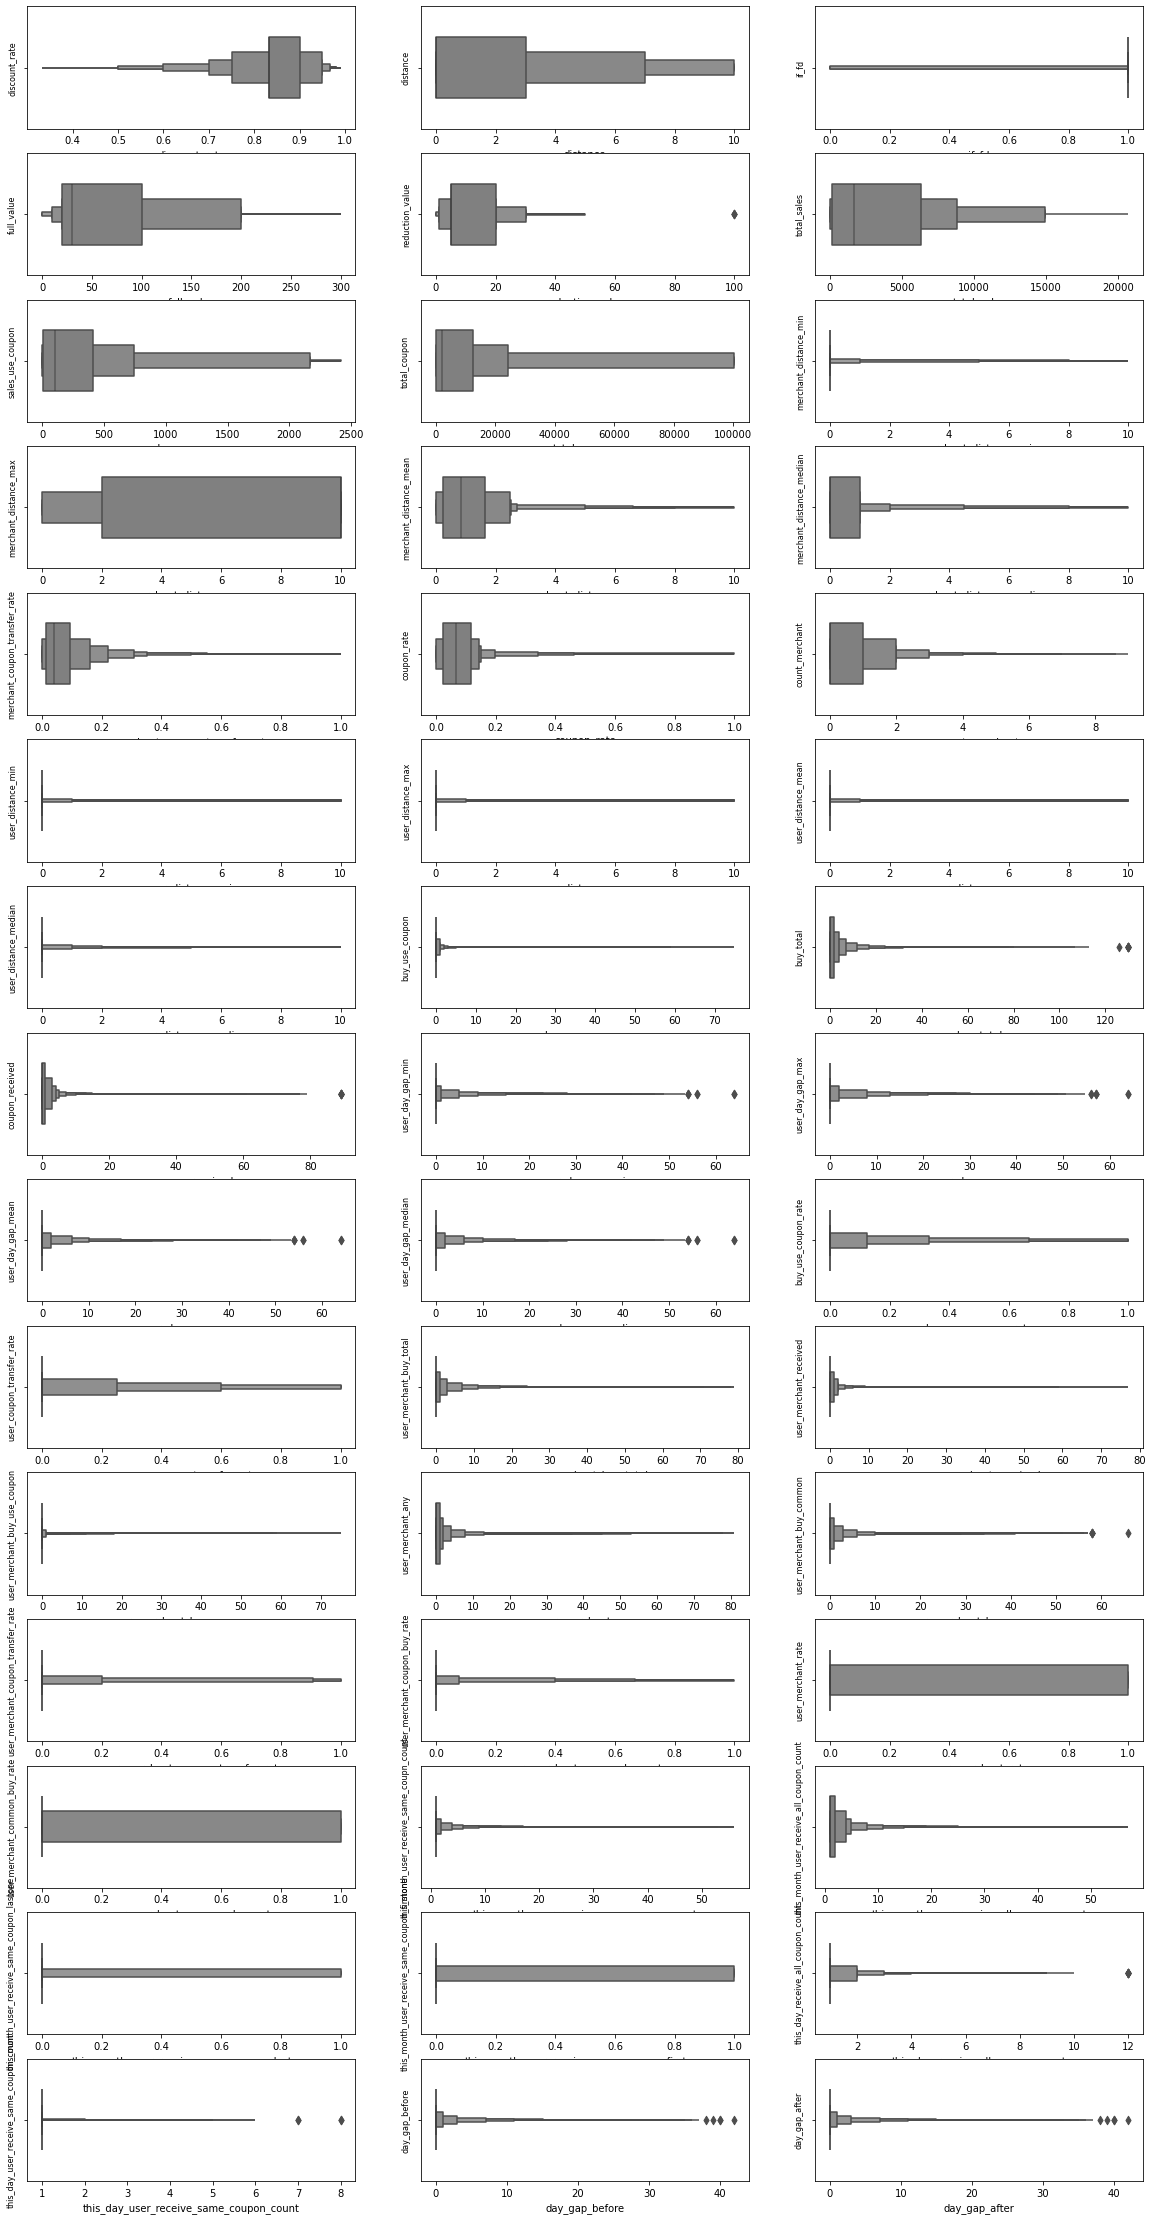

In [52]:
column = train_X.columns.tolist()[:46]
fig = plt.figure(figsize = (20, 40))
for i in range(45):
    plt.subplot(15, 3, i + 1)
    sns.boxenplot(train_X[column[i]], width = 0.5, color = "gray")
    plt.ylabel(column[i], fontsize = 8)
plt.show()

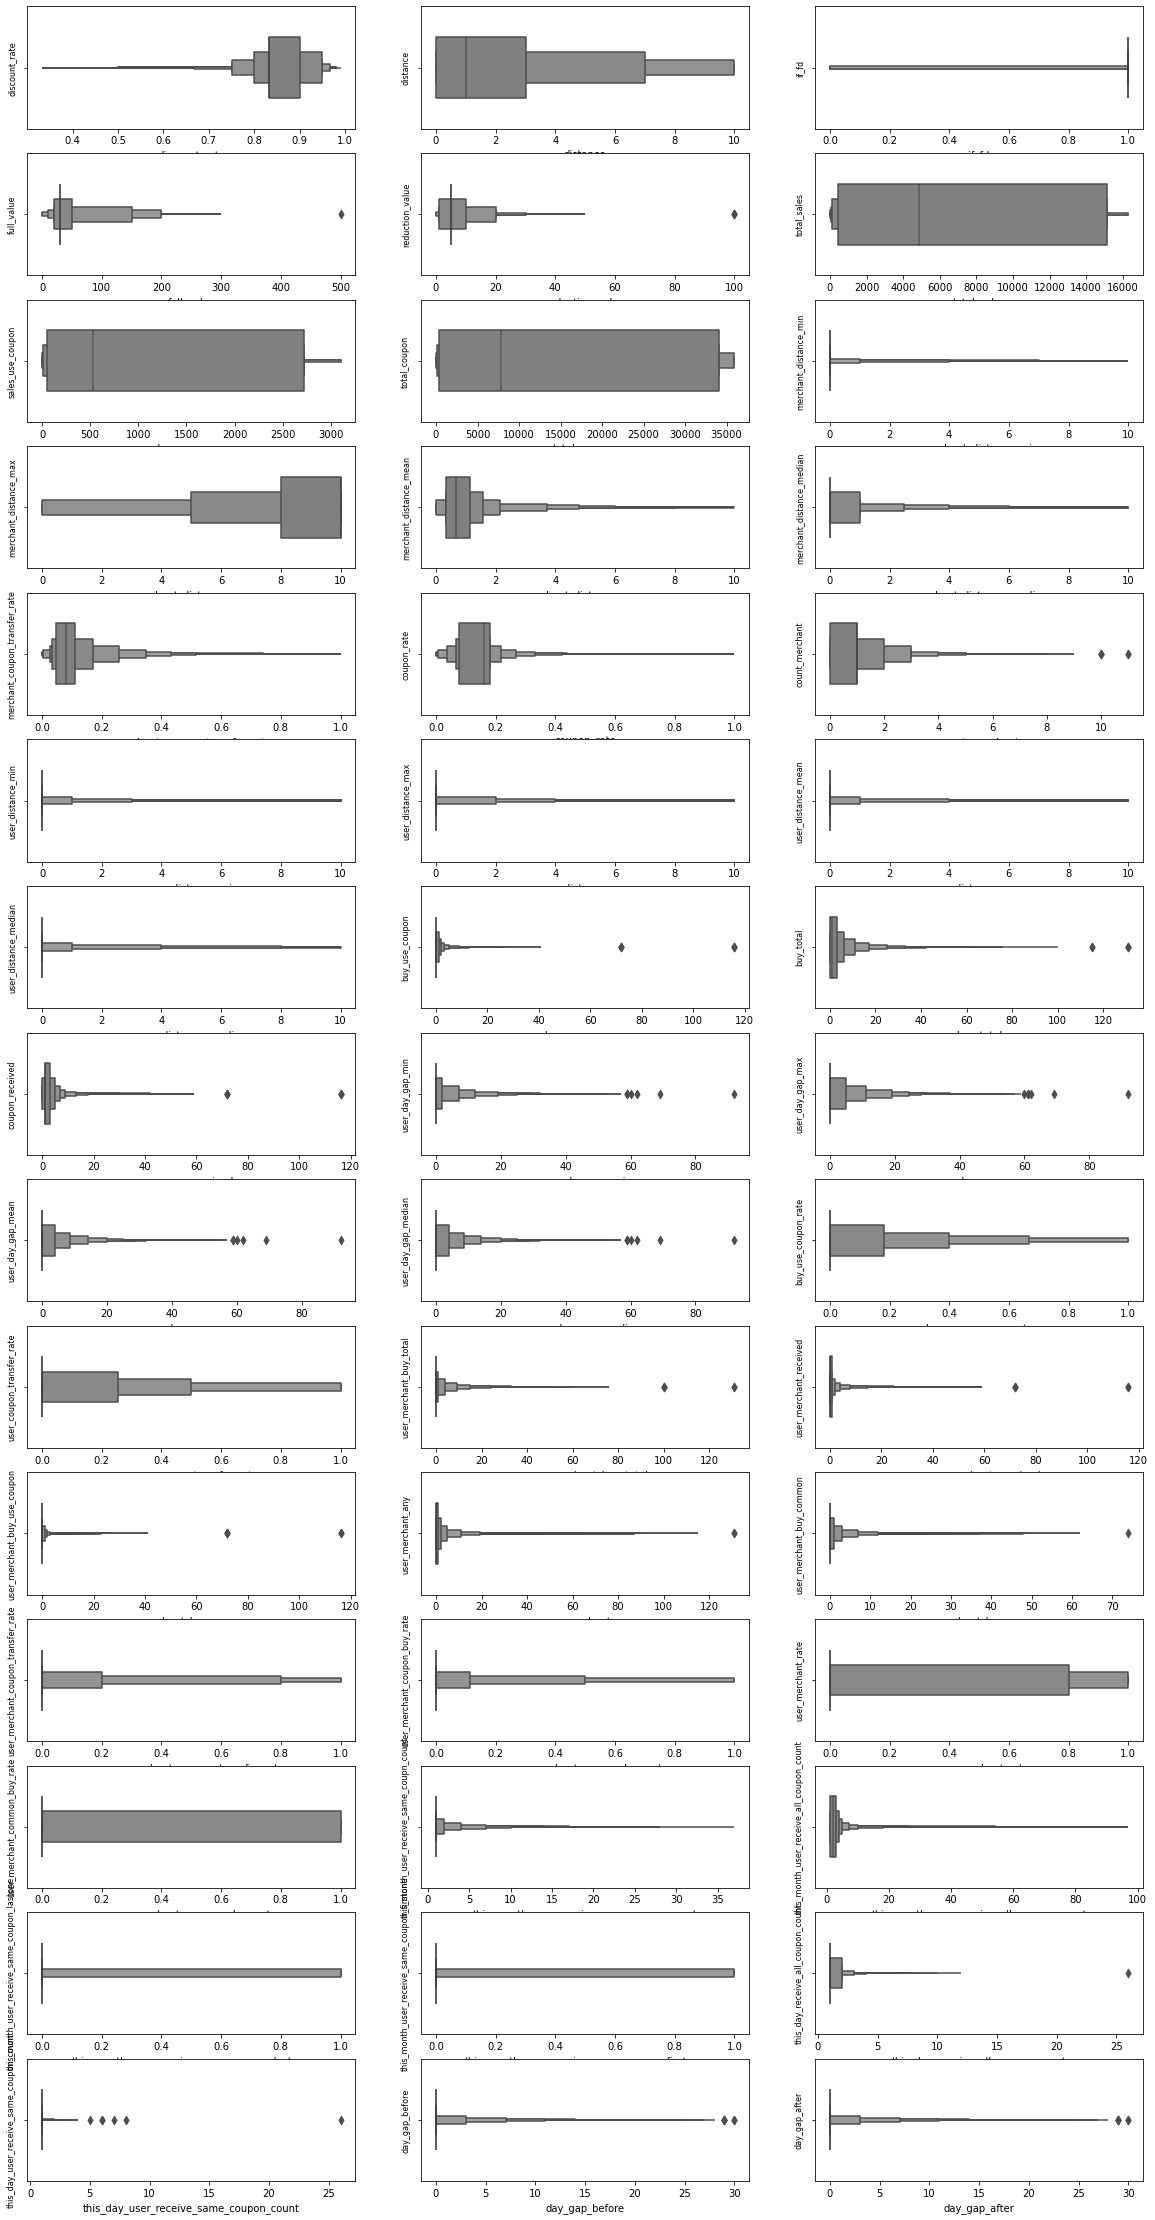

In [53]:
column = test_X.columns.tolist()[:46]
fig = plt.figure(figsize = (20, 40))
for i in range(45):
    plt.subplot(15, 3, i + 1)
    sns.boxenplot(test_X[column[i]], width = 0.5, color = "gray")
    plt.ylabel(column[i], fontsize = 8)
plt.show()

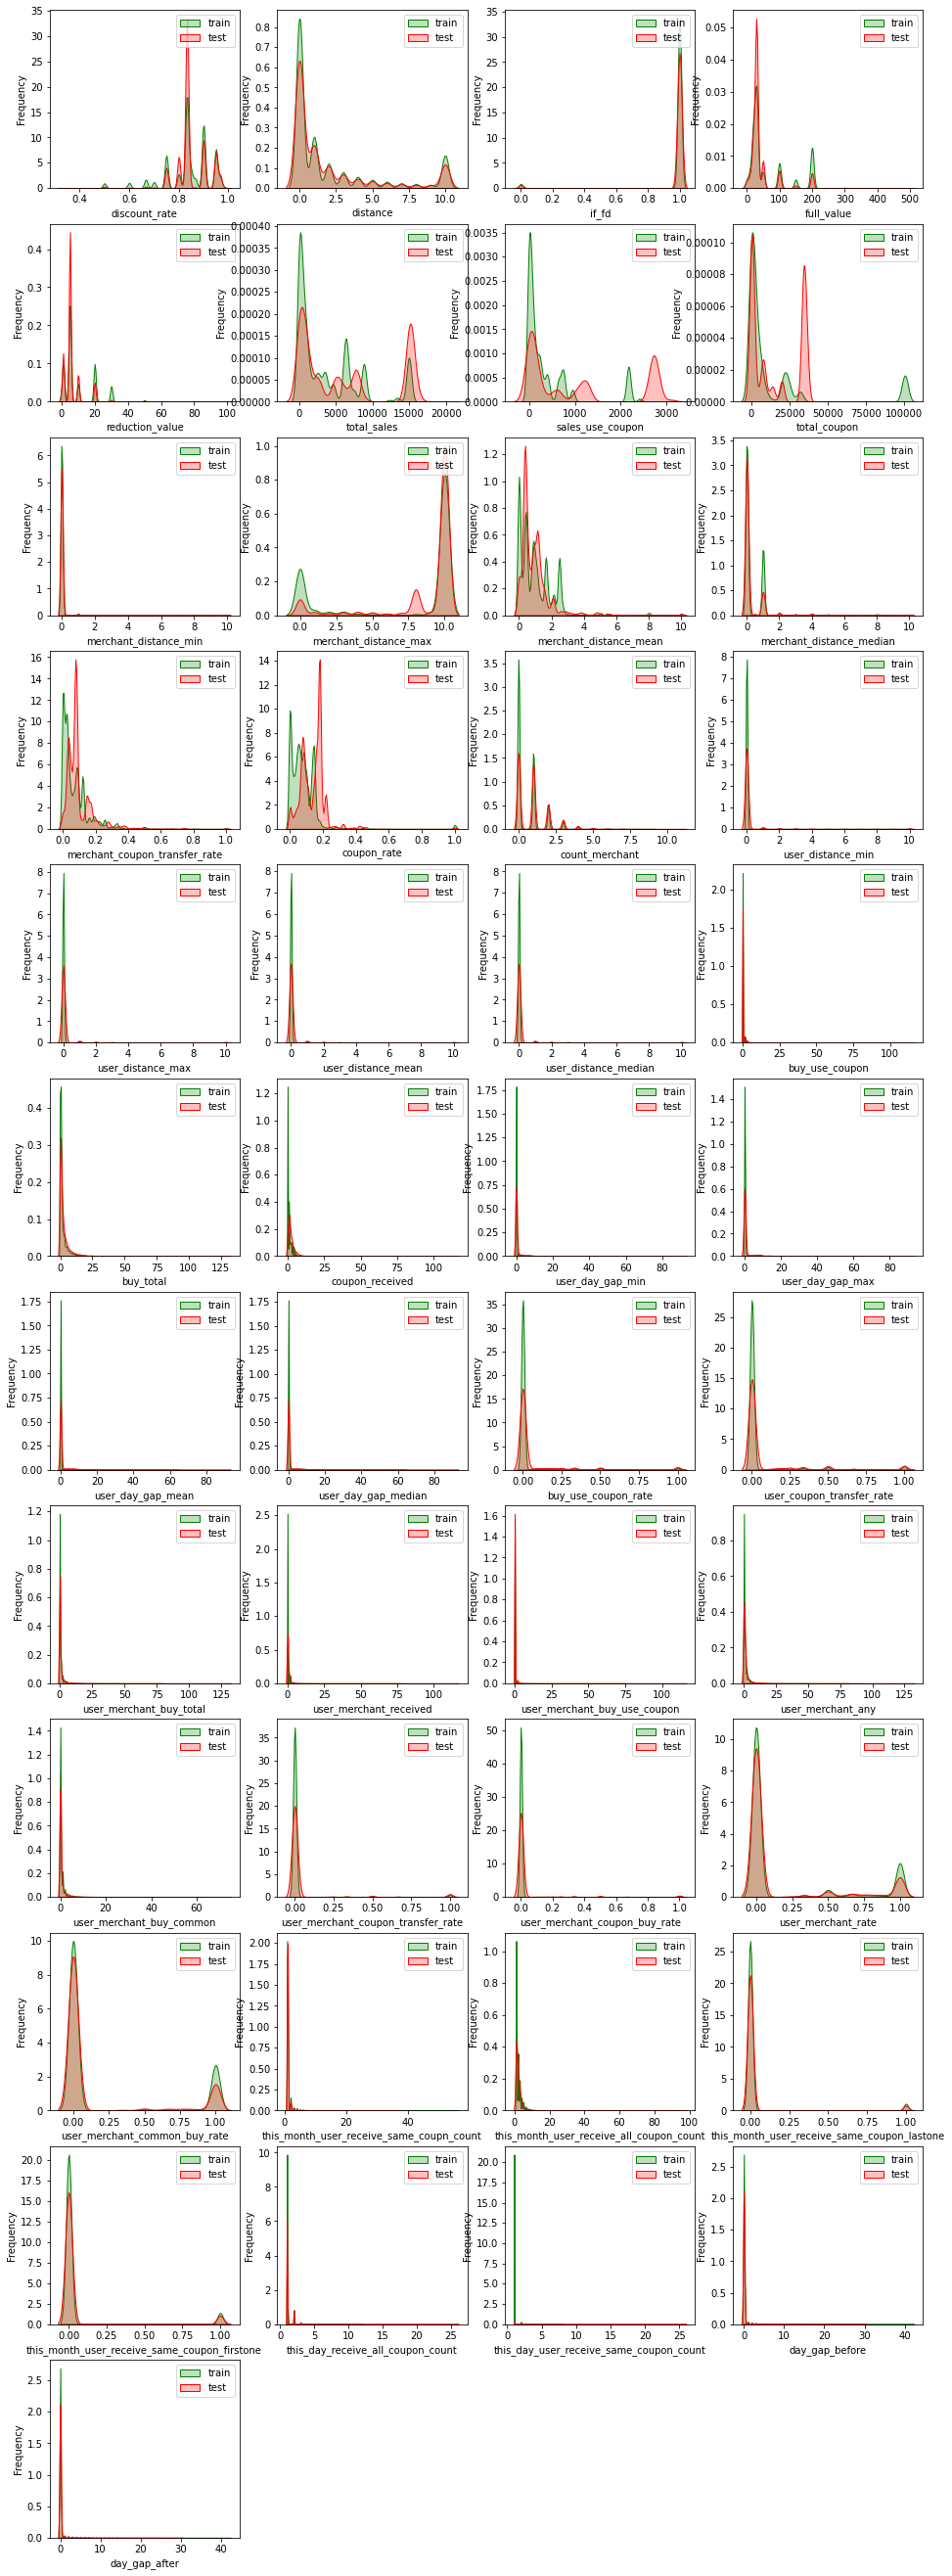

In [54]:
# train/test data distribution comparison
dist_cols = 4
dist_rows = len(test_X.columns)

plt.figure(figsize = (4 * dist_cols, 4 * dist_rows))

for i, col in enumerate(test_X.columns):
    ax = plt.subplot(dist_rows,dist_cols, i + 1)
    ax = sns.kdeplot(train_X[col], color = "green", shade = True)
    ax = sns.kdeplot(test_X[col], color = "red", shade = True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train","test"])
 
plt.show()

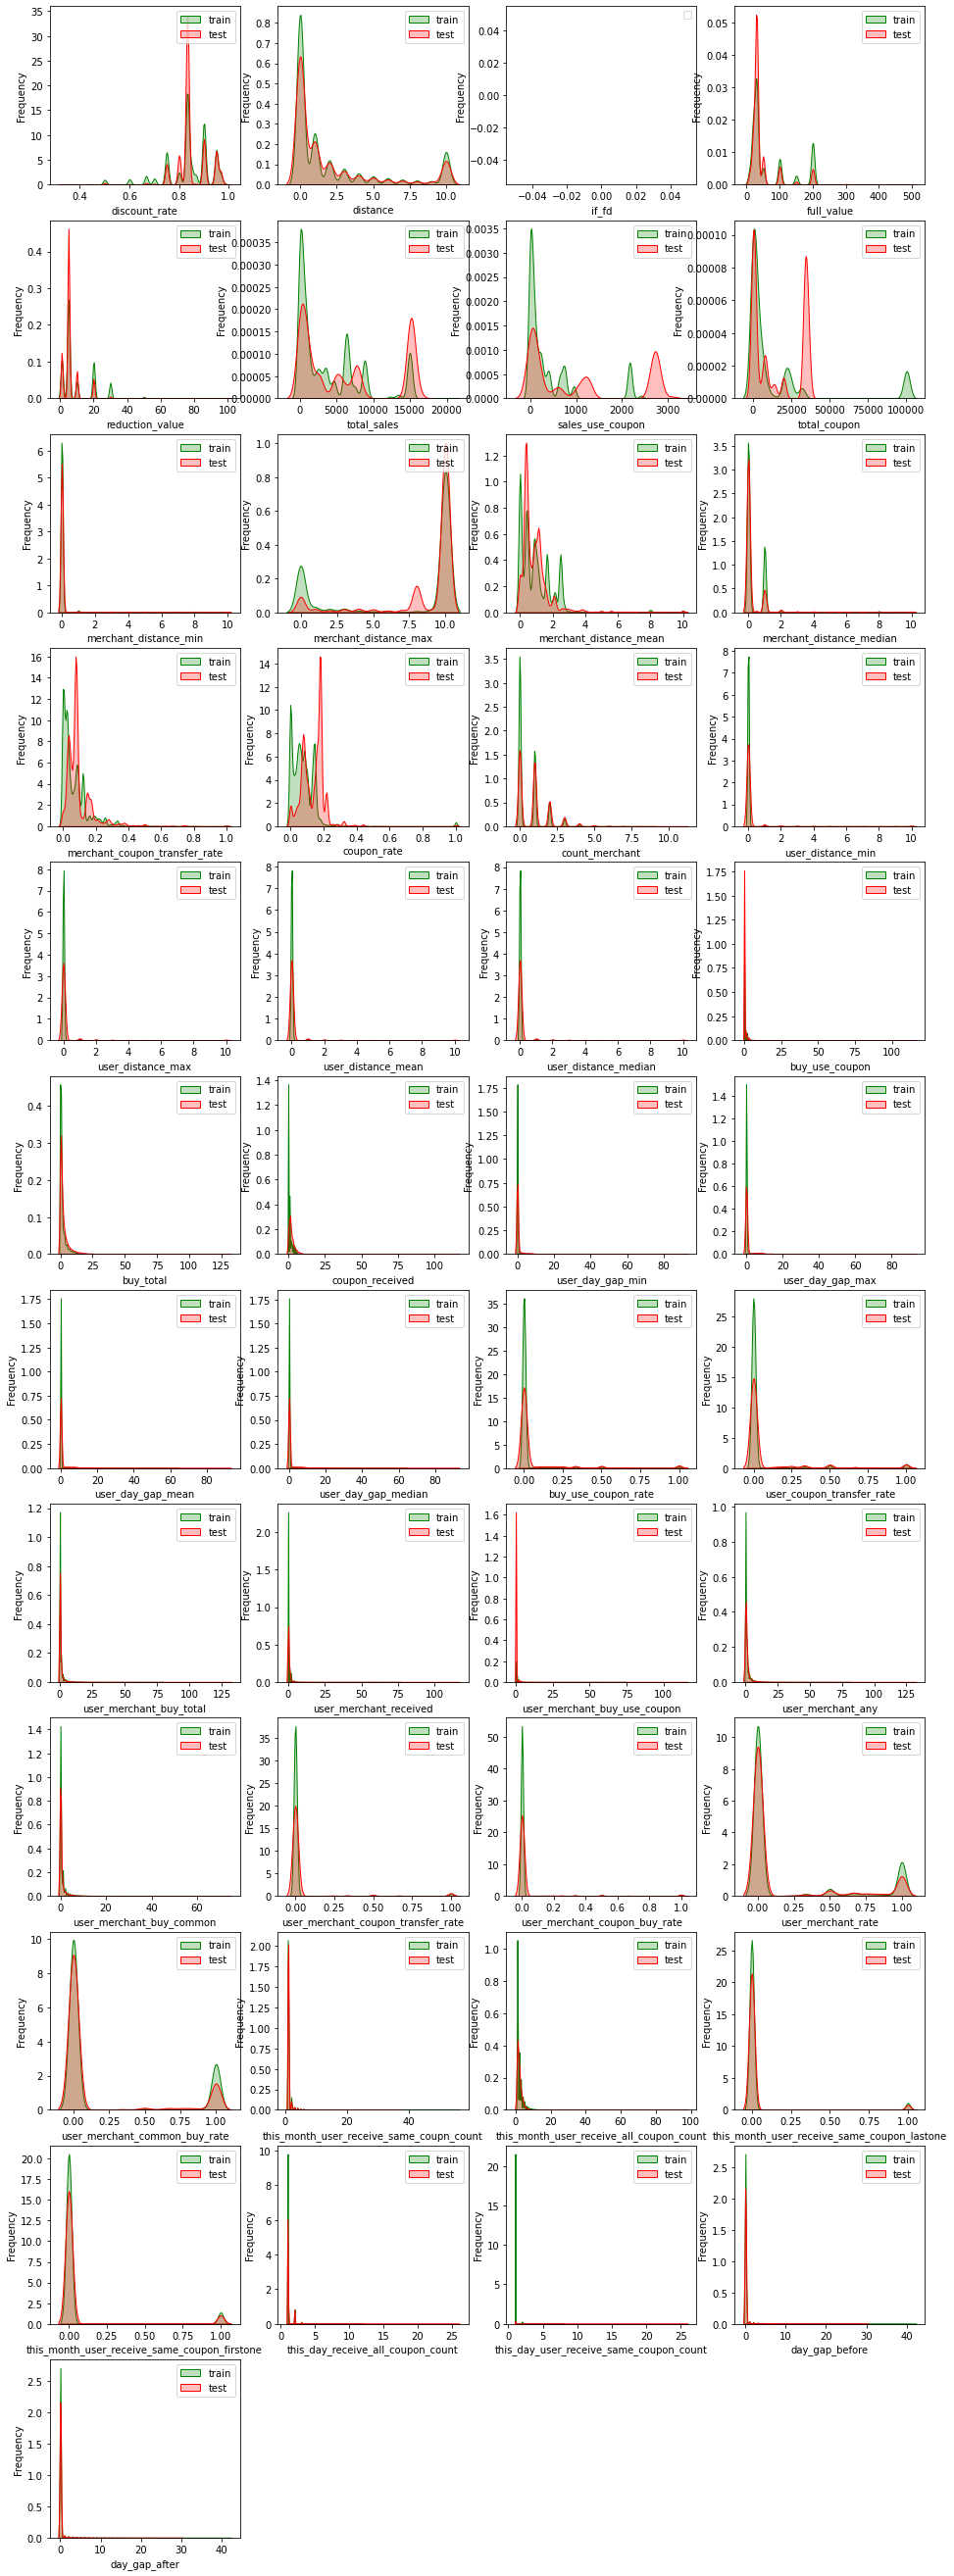

In [55]:
# train/test full reduction data distribution comparison
train_X_fd1 = train_X[train_X.if_fd == 1].reset_index(drop = True)
test_X_fd1 = test_X[test_X.if_fd == 1].reset_index(drop = True)
dist_cols = 4
dist_rows = len(test_X_fd1.columns)

plt.figure(figsize = (4 * dist_cols, 4 * dist_rows))

for i, col in enumerate(test_X_fd1.columns):
    ax = plt.subplot(dist_rows,dist_cols, i + 1)
    ax = sns.kdeplot(train_X_fd1[col], color = "green", shade = True)
    ax = sns.kdeplot(test_X_fd1[col], color = "red", shade = True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train","test"])
 
plt.show()

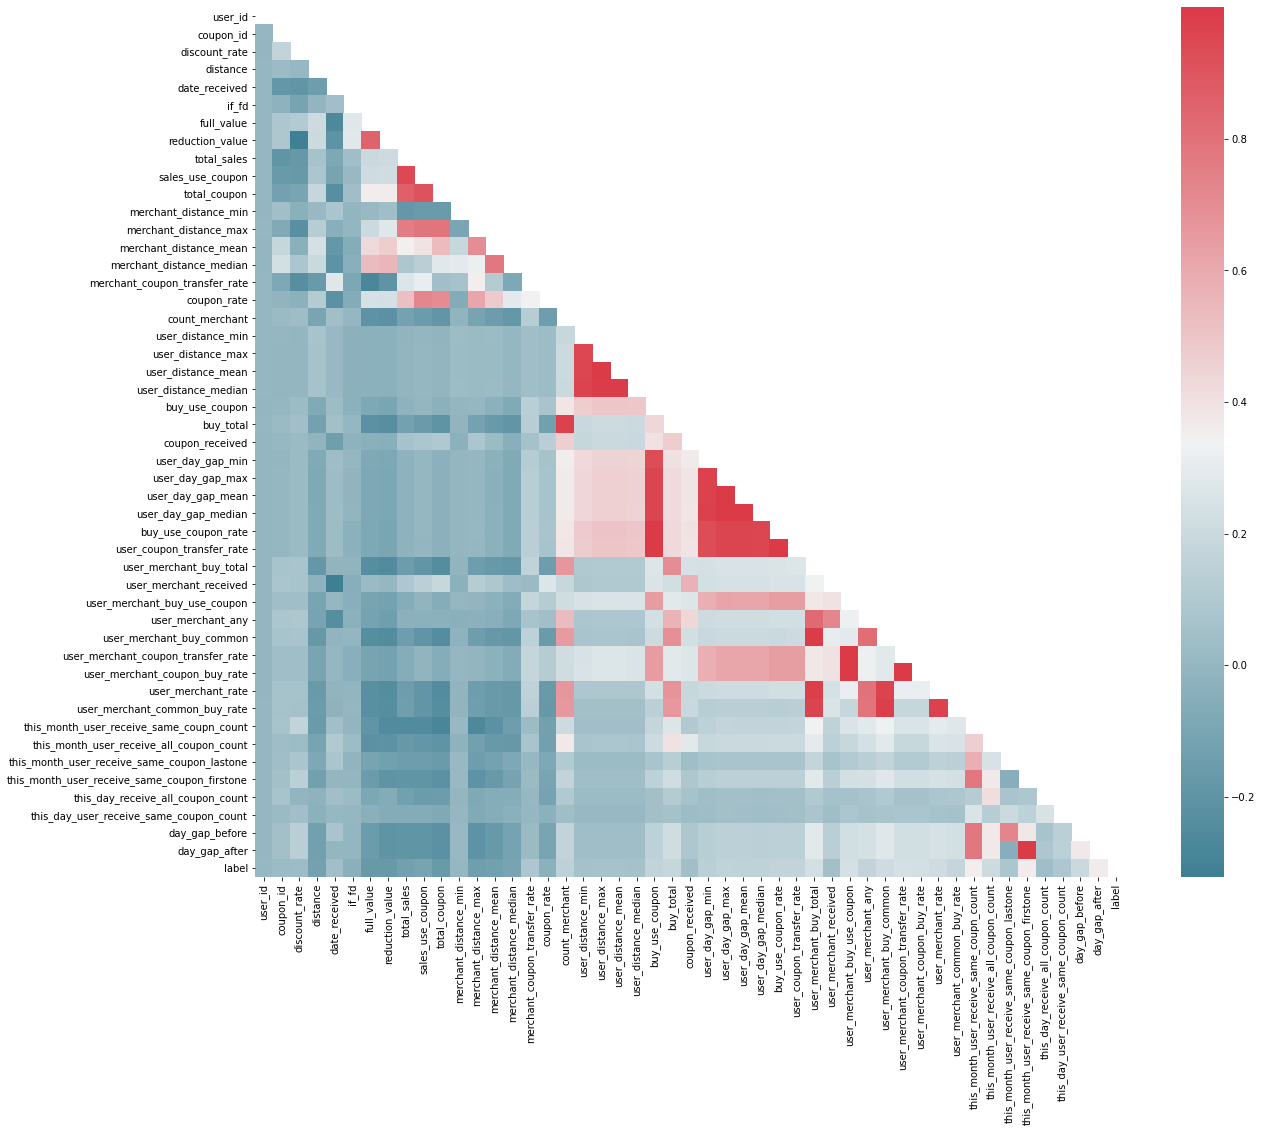

In [56]:
# Spearman correlation coeff. heatmap
plt.figure(figsize = (20, 16))
column = traindf.columns.tolist()
mcorr = traindf[column].corr(method = "spearman")
mask = np.zeros_like(mcorr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap = True)
g = sns.heatmap(mcorr, mask = mask, cmap = cmap, square = True, annot = False)
plt.show()

In [57]:
mcorr = mcorr.abs()
numerical_corr = mcorr[mcorr['label'] > 0.1]['label']
print(numerical_corr.sort_values(ascending = False))

label                                           1.000000
this_month_user_receive_same_coupon_firstone    0.364745
day_gap_after                                   0.360574
this_month_user_receive_same_coupn_count        0.350032
user_merchant_coupon_transfer_rate              0.231538
user_merchant_buy_use_coupon                    0.231087
user_merchant_buy_total                         0.230658
user_merchant_coupon_buy_rate                   0.229603
user_merchant_rate                              0.215392
user_merchant_buy_common                        0.214837
this_month_user_receive_all_coupon_count        0.208377
day_gap_before                                  0.199610
buy_total                                       0.182393
user_merchant_common_buy_rate                   0.178922
full_value                                      0.168628
user_coupon_transfer_rate                       0.168475
buy_use_coupon                                  0.168331
user_merchant_any              

In [58]:
# Scaling
def standize_df(train_data, test_data):
    from sklearn import preprocessing 
    
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])
    
    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])
    
    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns
    
    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns
    
    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler,test_data_scaler

# Modeling

In [59]:
# sklearn models
def get_sklearn_model(model_name, param = None):
    # naive Bayes
    if model_name == 'NB':
        return MultinomialNB(alpha = 0.01)
    # logistic regression
    elif model_name == 'LR':
        return LogisticRegression(penalty = 'l2')
    # KNN
    elif model_name == 'KNN':
        return KNeighborsClassifier()
    # decision tree
    elif model_name == 'DT':
        return tree.DecisionTreeClassifier()
    # random forest
    elif model_name == 'RF':
        return RandomForestClassifier()
    # SVM
    elif model_name == 'SVC':
        return SVC(kernel = 'rbf', probability=True)
    # GBDT
    elif model_name == 'GBDT':
        return GradientBoostingClassifier()
    # XGBoost
    elif model_name == 'XGB':
        return XGBClassifier(eval_metric = "auc")
    # lightGBM
    elif model_name == 'LGB':
        return LGBMClassifier()
    else:
        print("wrong model name!")

In [60]:
# plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt


# plot learning curve of models
def plot_curve_single(traindf,classifier,cvnum,train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]): 
    X = get_predictors_df(traindf)
    y = get_target_df(traindf)
    estimator = get_sklearn_model(classifier)
    title = "learning curve of "+classifier+", cv:"+str(cvnum)
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)

In [61]:
# auc eval
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)

# split by date
def test_model(traindf, classifier):
    train = traindf[traindf.date_received<20160515].copy()
    test = traindf[traindf.date_received>=20160515].copy()

    train_data = get_predictors_df(train).copy()
    train_target = get_target_df(train).copy()
    test_data = get_predictors_df(test).copy()
    test_target = get_target_df(test).copy()
    
    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:,1]
    test['pred'] = result
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+" total AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)


def test_model_split(traindf,classifier):
    
    target = get_target_df(traindf).copy()
    
    train_all,test_all,train_target,test_target = train_test_split(traindf,target,test_size=0.2,random_state=0)
    
    train_data = get_predictors_df(train_all).copy()
    test_data = get_predictors_df(test_all).copy()
    
    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:,1]
    
    test = test_all.copy()
    test['pred'] = result
    
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+"total AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)

In [62]:
train_f1,test_f1 = read_data('f1')
train_f1,test_f1 = standize_df(train_f1,test_f1)

train_f2,test_f2 = read_data('sf2')
train_f2,test_f2 = standize_df(train_f2,test_f2)

train_f3,test_f3 = read_data('sf3')
train_f3,test_f3 = standize_df(train_f3,test_f3)

In [63]:
train_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304509 entries, 0 to 304508
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   discount_rate    304509 non-null  float64
 1   distance         304509 non-null  float64
 2   if_fd            304509 non-null  float64
 3   full_value       304509 non-null  float64
 4   reduction_value  304509 non-null  float64
 5   label            304509 non-null  int64  
 6   user_id          304509 non-null  int64  
 7   coupon_id        304509 non-null  int64  
 8   date_received    304509 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 20.9 MB


In [64]:
train_f2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438166 entries, 0 to 438165
Data columns (total 41 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   discount_rate                       438166 non-null  float64
 1   distance                            438166 non-null  float64
 2   if_fd                               438166 non-null  float64
 3   full_value                          438166 non-null  float64
 4   reduction_value                     438166 non-null  float64
 5   total_sales                         438166 non-null  float64
 6   sales_use_coupon                    438166 non-null  float64
 7   total_coupon                        438166 non-null  float64
 8   merchant_distance_min               438166 non-null  float64
 9   merchant_distance_max               438166 non-null  float64
 10  merchant_distance_mean              438166 non-null  float64
 11  merchant_distance_median  

In [65]:
train_f3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438166 entries, 0 to 438165
Data columns (total 49 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   discount_rate                                 438166 non-null  float64
 1   distance                                      438166 non-null  float64
 2   if_fd                                         438166 non-null  float64
 3   full_value                                    438166 non-null  float64
 4   reduction_value                               438166 non-null  float64
 5   total_sales                                   438166 non-null  float64
 6   sales_use_coupon                              438166 non-null  float64
 7   total_coupon                                  438166 non-null  float64
 8   merchant_distance_min                         438166 non-null  float64
 9   merchant_distance_max                         43

In [66]:
print('f1 naive Bayes AUC')
test_model(train_f1,'NB')
print('sf2 naive Bayes AUC')
test_model(train_f2,'NB')
print('sf3 naive Bayes AUC')
test_model(train_f3,'NB')

f1 naive Bayes AUC
NB total AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647
sf2 naive Bayes AUC
NB total AUC: 0.7344423161179449
NB Coupon AUC: 0.6063348615415269
sf3 naive Bayes AUC
NB total AUC: 0.7812536833968516
NB Coupon AUC: 0.7119101385059943


In [67]:
print('f1 logistic regression AUC')
test_model(train_f1,'LR')
print('sf2 logistic regression AUC')
test_model(train_f2,'LR')
print('sf3 logistic regression AUC')
test_model(train_f3,'LR')

f1 logistic regression AUC
LR total AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647
sf2 logistic regression AUC
LR total AUC: 0.7603282848657191
LR Coupon AUC: 0.6029717296152599
sf3 logistic regression AUC
LR total AUC: 0.8100287812776621
LR Coupon AUC: 0.7290104334822116


In [68]:
print('f1 decision tree AUC')
test_model(train_f1,'DT')
print('sf2 decision tree AUC')
test_model(train_f2,'DT')
print('sf3 decision tree AUC')
test_model(train_f3,'DT')

f1 decision tree AUC
DT total AUC: 0.6481735302350922
DT Coupon AUC: 0.5303272197800327
sf2 decision tree AUC
DT total AUC: 0.5282506038418798
DT Coupon AUC: 0.5163216925777394
sf3 decision tree AUC
DT total AUC: 0.5634104632929565
DT Coupon AUC: 0.569719181702305


In [69]:
print('f1 random forest AUC')
test_model(train_f1,'RF')
print('sf2 random forest AUC')
test_model(train_f2,'RF')
print('sf3 random forest AUC')
test_model(train_f3,'RF')

f1 random forest AUC
RF total AUC: 0.6471529315147797
RF Coupon AUC: 0.5293432985146774
sf2 random forest AUC
RF total AUC: 0.6845017310371618
RF Coupon AUC: 0.566290982642282
sf3 random forest AUC
RF total AUC: 0.773609266895284
RF Coupon AUC: 0.7053781527967101


In [70]:
print('f1 GBDT AUC')
test_model(train_f1,'GBDT')
print('sf2 GBDT AUC')
test_model(train_f2,'GBDT')
print('sf3 GBDT AUC')
test_model(train_f3,'GBDT')

f1 GBDT AUC
GBDT total AUC: 0.6566797132349428
GBDT Coupon AUC: 0.533503980409598
sf2 GBDT AUC
GBDT total AUC: 0.7828284234752181
GBDT Coupon AUC: 0.6035246244236261
sf3 GBDT AUC
GBDT total AUC: 0.824234819120738
GBDT Coupon AUC: 0.7376779188946169


In [71]:
print('f1 LightGBM AUC')
test_model(train_f1,'LGB')
print('sf2 LightGBM AUC')
test_model(train_f2,'LGB')
print('sf3 LightGBM AUC')
test_model(train_f3,'LGB')

f1 LightGBM AUC
LGB total AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097
sf2 LightGBM AUC
LGB total AUC: 0.7741029767659218
LGB Coupon AUC: 0.5984526360012944
sf3 LightGBM AUC
LGB total AUC: 0.8284887876924993
LGB Coupon AUC: 0.7374344321731373


In [72]:
print('f1 XGBoost AUC')
test_model(train_f1,'XGB')
print('sf2 XGBoost AUC')
test_model(train_f2,'XGB')
print('sf3 XGBoost AUC')
test_model(train_f3,'XGB')

f1 XGBoost AUC
XGB total AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699
sf2 XGBoost AUC
XGB total AUC: 0.7274131700360452
XGB Coupon AUC: 0.5886899184606202
sf3 XGBoost AUC
XGB total AUC: 0.7973908059790942
XGB Coupon AUC: 0.7290342232690418


In [73]:
test_model(train_f1,'NB')

NB total AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647


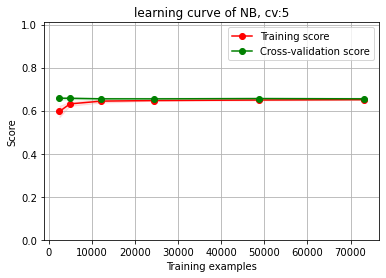

In [74]:
plot_curve_single(train_f1,'NB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [75]:
test_model(train_f1,'LR')

LR total AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647


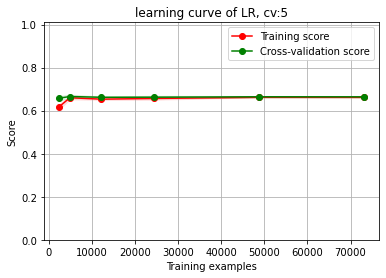

In [76]:
plot_curve_single(train_f1,'LR',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [77]:
test_model(train_f1,'KNN')

KNN total AUC: 0.5166435596945809
KNN Coupon AUC: 0.49904952962648


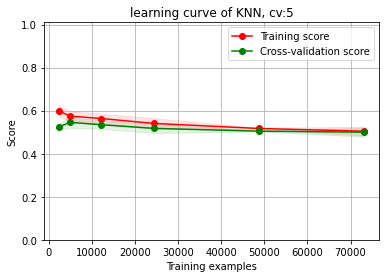

In [78]:
plot_curve_single(train_f1,'KNN',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [79]:
test_model(train_f1,'DT')

DT total AUC: 0.6481609737147687
DT Coupon AUC: 0.5302514392404754


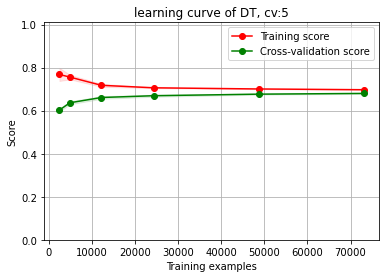

In [80]:
plot_curve_single(train_f1,'DT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [81]:
test_model(train_f1,'RF')

RF total AUC: 0.6478459516644031
RF Coupon AUC: 0.5300044343030518


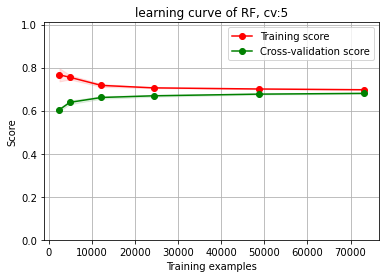

In [82]:
plot_curve_single(train_f1,'RF',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [83]:
test_model(train_f1,'GBDT')

GBDT total AUC: 0.6566794918883956
GBDT Coupon AUC: 0.533503980409598


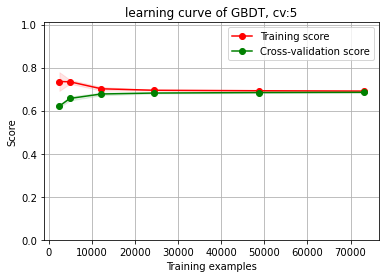

In [84]:
plot_curve_single(train_f1,'GBDT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [85]:
test_model(train_f1,'LGB')

LGB total AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097


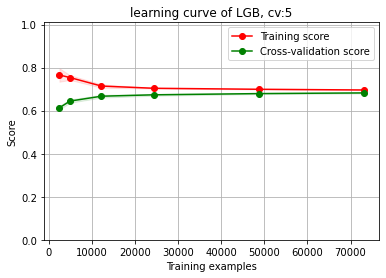

In [86]:
plot_curve_single(train_f1,'LGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [87]:
test_model(train_f1,'XGB')

XGB total AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699


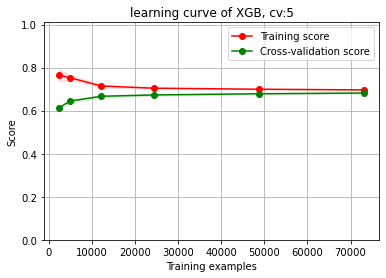

In [88]:
plot_curve_single(train_f1,'XGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

# Validation and optimization

In [89]:
# get train and test data with different features
train_f1, test_f1 = read_data('f1')
train_f2, test_f2 = read_data('sf2')
train_f3, test_f3 = read_data('sf3')

In [90]:
# cross validation f1, LR
from sklearn.model_selection import train_test_split
target = get_target_df(train_f1).copy()
traindf = train_f1.copy()
train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:,1]
test_pred = clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("LogisticRegression train total AUC:   ", score_train)
print("LogisticRegression test total AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train total AUC:    0.6638412716481189
LogisticRegression test total AUC:    0.6678435440703808
LogisticRegression train Coupon AUC:    0.540286974067141
LogisticRegression test Coupon AUC:    0.5410440709758992


In [91]:
# cross validation f1, XGB
from sklearn.model_selection import train_test_split
target = get_target_df(train_f1).copy()
traindf = train_f1.copy()
train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = XGBClassifier(eval_metric="auc")
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:,1]
test_pred = clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("XGBClassifier train total AUC:   ", score_train)
print("XGBClassifier test total AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("XGBClassifier train Coupon AUC:   ", myauc(train_all))
print("XGBClassifier test Coupon AUC:   ", myauc(test_all))

XGBClassifier train total AUC:    0.6908764564642371
XGBClassifier test total AUC:    0.6861549562186964
XGBClassifier train Coupon AUC:    0.5489493170035781
XGBClassifier test Coupon AUC:    0.5385927762132738


In [92]:
# cross validation f2, LR
from sklearn.model_selection import train_test_split
target = get_target_df(train_f2).copy()
traindf = train_f2.copy()
train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:,1]
test_pred = clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("LogisticRegression train total AUC:   ", score_train)
print("LogisticRegression test total AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train total AUC:    0.7621096810519392
LogisticRegression test total AUC:    0.7599294405101087
LogisticRegression train Coupon AUC:    0.597778197911254
LogisticRegression test Coupon AUC:    0.6062388079924907


In [93]:
# cross validation f2, XGB
from sklearn.model_selection import train_test_split
target = get_target_df(train_f2).copy()
traindf = train_f2.copy()
train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = XGBClassifier(eval_metric="auc")
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:,1]
test_pred = clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("XGBClassifier train total AUC:   ", score_train)
print("XGBClassifier test total AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("XGBClassifier train Coupon AUC:   ", myauc(train_all))
print("XGBClassifier test Coupon AUC:   ", myauc(test_all))

XGBClassifier train total AUC:    0.8845155621260052
XGBClassifier test total AUC:    0.8701698732477811
XGBClassifier train Coupon AUC:    0.6649613989177482
XGBClassifier test Coupon AUC:    0.6353634057597716


In [94]:
# cross validation f3, LR
from sklearn.model_selection import train_test_split
target = get_target_df(train_f3).copy()
traindf = train_f3.copy()
train_all,test_all,train_target,test_target = train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:,1]
test_pred = clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("LogisticRegression train total AUC:   ", score_train)
print("LogisticRegression test total AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train total AUC:    0.7791630158645071
LogisticRegression test total AUC:    0.7781225413447534
LogisticRegression train Coupon AUC:    0.6714577925733559
LogisticRegression test Coupon AUC:    0.6862536911995071


In [95]:
# cross validation f3, XGB
from sklearn.model_selection import train_test_split
target = get_target_df(train_f3).copy()
traindf = train_f3.copy()
train_all,test_all,train_target,test_target = train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = XGBClassifier(eval_metric="auc")
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:,1]
test_pred = clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("XGBClassifier train total AUC:   ", score_train)
print("XGBClassifier test total AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("XGBClassifier train Coupon AUC:   ", myauc(train_all))
print("XGBClassifier test Coupon AUC:   ", myauc(test_all))

XGBClassifier train total AUC:    0.9130247454397008
XGBClassifier test total AUC:    0.9023556597977016
XGBClassifier train Coupon AUC:    0.786157847023454
XGBClassifier test Coupon AUC:    0.7764618632548401


In [96]:
# k (=5) fold cross validation f3, LR
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = LogisticRegression() 
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred = clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k+1, " fold", "LogisticRegression train total AUC:   ", score_train)
    print(k+1, " fold", "LogisticRegression test total AUC:   ", score_test)  
    print(k+1, " fold", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k+1, " fold", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n')

1  fold LogisticRegression train total AUC:    0.7464138081555902
1  fold LogisticRegression test total AUC:    0.8093233465283305
1  fold LogisticRegression train Coupon AUC:    0.6250987439992082
1  fold LogisticRegression test Coupon AUC:    0.6400702669854228 

2  fold LogisticRegression train total AUC:    0.7676763736097758
2  fold LogisticRegression test total AUC:    0.8219214247819128
2  fold LogisticRegression train Coupon AUC:    0.6709523625982364
2  fold LogisticRegression test Coupon AUC:    0.677470613280263 

3  fold LogisticRegression train total AUC:    0.7653490995432924
3  fold LogisticRegression test total AUC:    0.7301517799286368
3  fold LogisticRegression train Coupon AUC:    0.6366359262820874
3  fold LogisticRegression test Coupon AUC:    0.6545117572152132 

4  fold LogisticRegression train total AUC:    0.7869003061682388
4  fold LogisticRegression test total AUC:    0.7472063023888631
4  fold LogisticRegression train Coupon AUC:    0.6710655754066711
4  fo

In [97]:
# k (=5) fold cross validation f3, XGB
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = XGBClassifier(eval_metric="auc")
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred = clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k+1, " fold", "XGBClassifier train total AUC:   ", score_train)
    print(k+1, " fold", "XGBClassifier test total AUC:   ", score_test)  
    print(k+1, " fold", "XGBClassifier train Coupon AUC:   ", myauc(train_data))
    print(k+1, " fold", "XGBClassifier test Coupon AUC:   ", myauc(test_data), '\n')

1  fold XGBClassifier train total AUC:    0.9104129389795352
1  fold XGBClassifier test total AUC:    0.9082373528414449
1  fold XGBClassifier train Coupon AUC:    0.785285831690946
1  fold XGBClassifier test Coupon AUC:    0.7456807170783417 

2  fold XGBClassifier train total AUC:    0.9107269242128339
2  fold XGBClassifier test total AUC:    0.9062056575701329
2  fold XGBClassifier train Coupon AUC:    0.7860190578306557
2  fold XGBClassifier test Coupon AUC:    0.7392900571460916 

3  fold XGBClassifier train total AUC:    0.9174827616479324
3  fold XGBClassifier test total AUC:    0.8856091790561942
3  fold XGBClassifier train Coupon AUC:    0.7861502707639707
3  fold XGBClassifier test Coupon AUC:    0.7480755658972293 

4  fold XGBClassifier train total AUC:    0.9170777555375993
4  fold XGBClassifier test total AUC:    0.8847427568295814
4  fold XGBClassifier train Coupon AUC:    0.7835354682053496
4  fold XGBClassifier test Coupon AUC:    0.7617726102784477 

5  fold XGBClassi

In [98]:
# LPO CV f3
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import LeavePOut
lpo = LeavePOut(p = 200)
num = 100
for k, (train_index, test_index) in enumerate(lpo.split(train)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = LogisticRegression() 
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred = clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k+1, " fold", "LogisticRegression train total AUC:   ", score_train)
    print(k+1, " fold", "LogisticRegression test total AUC:   ", score_test)  
    print(k+1, " fold", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k+1, " fold", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n')
    if k >= 5:
        break

1  fold LogisticRegression train total AUC:    0.7572552914591816
1  fold LogisticRegression test total AUC:    0.8255762411347518
1  fold LogisticRegression train Coupon AUC:    0.6234908569100651
1  fold LogisticRegression test Coupon AUC:    0.3026315789473684 

2  fold LogisticRegression train total AUC:    0.7589589131784805
2  fold LogisticRegression test total AUC:    0.8366578014184397
2  fold LogisticRegression train Coupon AUC:    0.6375370806003697
2  fold LogisticRegression test Coupon AUC:    0.35 

3  fold LogisticRegression train total AUC:    0.7573077488441928
3  fold LogisticRegression test total AUC:    0.8233599290780143
3  fold LogisticRegression train Coupon AUC:    0.6235448870511632
3  fold LogisticRegression test Coupon AUC:    0.3026315789473684 

4  fold LogisticRegression train total AUC:    0.7795990702399525
4  fold LogisticRegression test total AUC:    0.8371010638297872
4  fold LogisticRegression train Coupon AUC:    0.6670476757861614
4  fold LogisticRe

In [99]:
# StratifiedKFold f3, LR
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits = 5)
for k, (train_index, test_index) in enumerate(kf.split(train,target)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = LogisticRegression() 
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred = clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k+1, " fold", "LogisticRegression train total AUC:   ", score_train)
    print(k+1, " fold", "LogisticRegression test total AUC:   ", score_test)  
    print(k+1, " fold", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k+1, " fold", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n') 

1  fold LogisticRegression train total AUC:    0.7544251059383554
1  fold LogisticRegression test total AUC:    0.823725659607057
1  fold LogisticRegression train Coupon AUC:    0.6640708282796405
1  fold LogisticRegression test Coupon AUC:    0.6706860881101916 

2  fold LogisticRegression train total AUC:    0.7701861265519091
2  fold LogisticRegression test total AUC:    0.8166552963736928
2  fold LogisticRegression train Coupon AUC:    0.6681761197279078
2  fold LogisticRegression test Coupon AUC:    0.6715843759689184 

3  fold LogisticRegression train total AUC:    0.7819284885216482
3  fold LogisticRegression test total AUC:    0.7574987574276375
3  fold LogisticRegression train Coupon AUC:    0.6666045664703746
3  fold LogisticRegression test Coupon AUC:    0.6760024525830651 

4  fold LogisticRegression train total AUC:    0.7865122379641537
4  fold LogisticRegression test total AUC:    0.7422424869008337
4  fold LogisticRegression train Coupon AUC:    0.6717913198197041
4  fo

In [100]:
# StratifiedKFold f3, XGB
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits = 5)
for k, (train_index, test_index) in enumerate(kf.split(train,target)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = XGBClassifier(eval_metric="auc")
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred = clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k+1, " fold", "XGBClassifier train total AUC:   ", score_train)
    print(k+1, " fold", "XGBClassifier test total AUC:   ", score_test)  
    print(k+1, " fold", "XGBClassifier train Coupon AUC:   ", myauc(train_data))
    print(k+1, " fold", "XGBClassifier test Coupon AUC:   ", myauc(test_data), '\n') 

1  fold XGBClassifier train total AUC:    0.9124434457555216
1  fold XGBClassifier test total AUC:    0.9037209962812665
1  fold XGBClassifier train Coupon AUC:    0.786837557246589
1  fold XGBClassifier test Coupon AUC:    0.7378876764625137 

2  fold XGBClassifier train total AUC:    0.9115742363950202
2  fold XGBClassifier test total AUC:    0.9051769653169095
2  fold XGBClassifier train Coupon AUC:    0.7898207761214443
2  fold XGBClassifier test Coupon AUC:    0.7329233226761875 

3  fold XGBClassifier train total AUC:    0.9163815579436445
3  fold XGBClassifier test total AUC:    0.8845052015307229
3  fold XGBClassifier train Coupon AUC:    0.7858521133153022
3  fold XGBClassifier test Coupon AUC:    0.7459996686225314 

4  fold XGBClassifier train total AUC:    0.9170321114130412
4  fold XGBClassifier test total AUC:    0.8832468276965647
4  fold XGBClassifier train Coupon AUC:    0.7826492315038752
4  fold XGBClassifier test Coupon AUC:    0.7608600778233133 

5  fold XGBClassi

In [101]:
def classifier_df_score(train_feat,classifier,cvnum,param=None):  
    clf = get_sklearn_model(classifier,param)
    train = train_feat.copy()
    target = get_target_df(train_feat).copy()
    kf = StratifiedKFold(n_splits=cvnum)
    
    scores = []
    score_coupons = []
    for k, (train_index, test_index) in enumerate(kf.split(train,target)):
        train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
        clf.fit(get_predictors_df(train_data), train_target) 
        train_pred = clf.predict_proba(get_predictors_df(train_data))[:,1]
        test_pred = clf.predict_proba(get_predictors_df(test_data))[:,1]
        
        score_test = roc_auc_score(test_target, test_pred)
        test_data['pred'] = test_pred
        score_coupon_test = myauc(test_data)
        
        scores.append(score_test)
        score_coupons.append(score_coupon_test)
        
    print (classifier+" total AUC:",scores)
    print (classifier+" Coupon AUC:",score_coupons)
    return scores, score_coupons

In [102]:
# f1 feature train set
train = train_f1.copy()

In [103]:
# f1, different models 5 fold training AUC
allScores = []
allScoreCoupons = []
labels = ["NB", "LR", "RF", "DT", "GBDT", "XGB", "LGB"]
print ('f1, different models 5 fold training AUC：')
score1, scoreC = classifier_df_score(train,'NB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'LR', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'RF', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'DT', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'GBDT', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'XGB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'LGB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

f1, different models 5 fold training AUC：
NB total AUC: [0.6573174183883979, 0.6616786712264662, 0.6649809851465509, 0.6607940927262956, 0.6697966362930912]
NB Coupon AUC: [0.5363631418076686, 0.5338265093921163, 0.5334927461290747, 0.5415356445668099, 0.5384562409294064]
LR total AUC: [0.6631905504987429, 0.6610342322208508, 0.6642214432041805, 0.662701091887288, 0.6709387991179554]
LR Coupon AUC: [0.5363631418076686, 0.5338265093921163, 0.5334927461290747, 0.5415356445668099, 0.5384562409294064]
RF total AUC: [0.6842987080238234, 0.6839072317980017, 0.6844895569036452, 0.682082534689002, 0.686749980425846]
RF Coupon AUC: [0.5318826811590495, 0.5264352125623833, 0.5216230898842563, 0.5298389983607198, 0.5394801377032175]
DT total AUC: [0.6842216318292198, 0.6840753707734994, 0.6843096301608347, 0.6820802105231385, 0.686594479780588]
DT Coupon AUC: [0.5311379679545325, 0.5267361593162548, 0.5216855196149904, 0.5286561734556614, 0.5386983203507605]
GBDT total AUC: [0.6857057651771316, 0

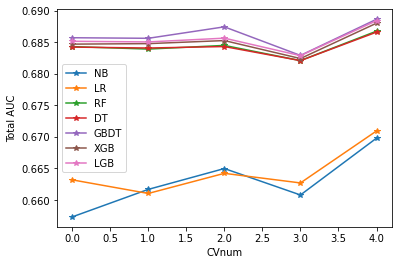

In [104]:
# f1, total AUC
for i in range(len(allScores)):
    plt.plot(allScores[i], marker = "*", label = labels[i])
plt.xlabel("CVnum")
plt.ylabel("Total AUC")
plt.legend()

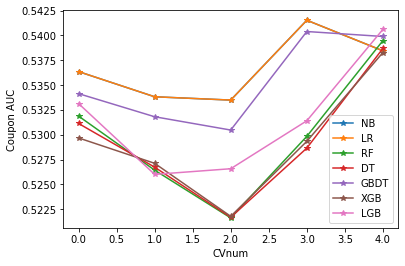

In [105]:
# f1, coupon AUC
for i in range(len(allScoreCoupons)):
    plt.plot(allScoreCoupons[i], marker = "*", label = labels[i])
plt.xlabel("CVnum")
plt.ylabel("Coupon AUC")
plt.legend()

In [106]:
# f2 feature train set
train = train_f2.copy()

In [107]:
# f2, different models 5 fold training AUC
allScores = []
allScoreCoupons = []
labels = ["NB", "LR", "RF", "DT", "GBDT", "XGB", "LGB"]
print ('f2, different models 5 fold training AUC：')
score1, scoreC = classifier_df_score(train,'NB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'LR', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'RF', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'DT', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'GBDT', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'XGB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'LGB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

f2, different models 5 fold training AUC：
NB total AUC: [0.713938519595792, 0.7258558423027714, 0.5556471174581836, 0.5336285792547653, 0.5316962623805122]
NB Coupon AUC: [0.5275503482064026, 0.5346387836236437, 0.5096119547539045, 0.5101441190539506, 0.5044511144113633]
LR total AUC: [0.8054851796231599, 0.7958546184153608, 0.7315330605262705, 0.7140087385782581, 0.7146777731486039]
LR Coupon AUC: [0.601768179225062, 0.58752826447523, 0.5755760783305571, 0.5843657637019692, 0.5884675555950573]
RF total AUC: [0.7930608420997969, 0.7904528754350755, 0.767438923875218, 0.7770307446902764, 0.7910914307378534]
RF Coupon AUC: [0.5787801440219386, 0.5408046423924339, 0.529310618488572, 0.5554758395569206, 0.5653725823877007]
DT total AUC: [0.5918655631375054, 0.589526089830494, 0.595558359046749, 0.6060008332842604, 0.6210109374713306]
DT Coupon AUC: [0.5226539666509088, 0.49693358703713214, 0.5004765273994086, 0.5197386052429349, 0.522894870492785]
GBDT total AUC: [0.8601955477418546, 0.858

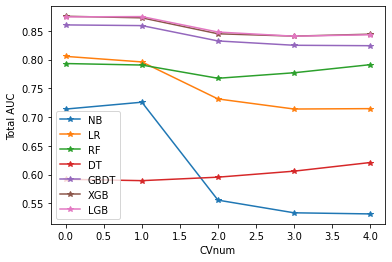

In [108]:
# f2, total AUC
for i in range(len(allScores)):
    plt.plot(allScores[i], marker = "*", label = labels[i])
plt.xlabel("CVnum")
plt.ylabel("Total AUC")
plt.legend()

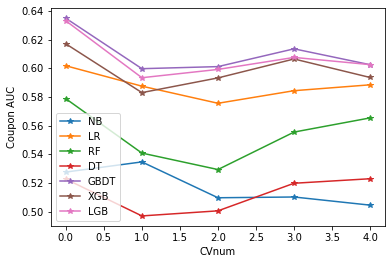

In [109]:
# f2, coupon AUC
for i in range(len(allScoreCoupons)):
    plt.plot(allScoreCoupons[i], marker = "*", label = labels[i])
plt.xlabel("CVnum")
plt.ylabel("Coupon AUC")
plt.legend()

In [110]:
# f3 feature train set
train = train_f3.copy()

In [111]:
# f3, different models 5 fold training AUC
allScores = []
allScoreCoupons = []
labels = ["NB", "LR", "RF", "DT", "GBDT", "XGB", "LGB"]
print ('f3, different models 5 fold training AUC：')
score1, scoreC = classifier_df_score(train,'NB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'LR', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'RF', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'DT', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'GBDT', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'XGB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

score1, scoreC = classifier_df_score(train,'LGB', 5)
allScores.append(score1)
allScoreCoupons.append(scoreC)

f3, different models 5 fold training AUC：
NB total AUC: [0.7226689251545343, 0.7326689957928132, 0.5666685299331358, 0.5445688768937752, 0.546229246344071]
NB Coupon AUC: [0.548959359622655, 0.553100615707808, 0.5257675104584291, 0.5214796518632205, 0.5211817732351175]
LR total AUC: [0.823725659607057, 0.8166552963736928, 0.7574987574276375, 0.7422424869008337, 0.7211149966427419]
LR Coupon AUC: [0.6706860881101916, 0.6715843759689184, 0.6760024525830651, 0.6829586038209605, 0.6481388752601901]
RF total AUC: [0.8567493762944293, 0.8600594908565626, 0.8465363201968494, 0.8454675400311481, 0.849310168215115]
RF Coupon AUC: [0.7196840789942245, 0.7002015041109501, 0.6994317514934864, 0.7222440245135832, 0.7205812208459925]
DT total AUC: [0.6268234675136533, 0.6417958538082726, 0.6351988386135223, 0.6435272245099471, 0.6520295881043455]
DT Coupon AUC: [0.5792867185730222, 0.5766059363223665, 0.5848141059025731, 0.5850738824621025, 0.5912956330530804]
GBDT total AUC: [0.8890447663850434, 0.

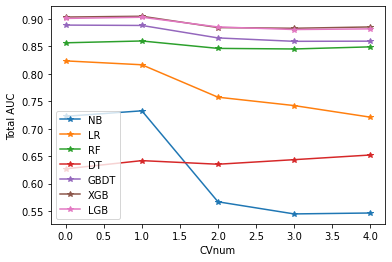

In [112]:
# f3, total AUC
for i in range(len(allScores)):
    plt.plot(allScores[i], marker = "*", label = labels[i])
plt.xlabel("CVnum")
plt.ylabel("Total AUC")
plt.legend()

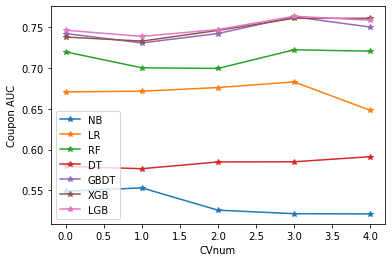

In [113]:
# f3, coupon AUC
for i in range(len(allScoreCoupons)):
    plt.plot(allScoreCoupons[i], marker = "*", label = labels[i])
plt.xlabel("CVnum")
plt.ylabel("Coupon AUC")
plt.legend()